In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys, os
pwd = os.getcwd()
sys.path.append(pwd)
import main as src
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white', color_codes=True)
import scipy, umap, glob, random

from scipy import stats
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_1samp, ttest_ind, f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier

from natsort import natsorted

seed = 42
%matplotlib inline

<h1>Data loading and initialization</h1>

<Figure size 432x288 with 0 Axes>

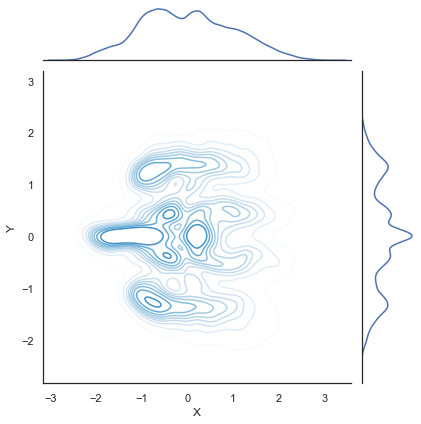

In [2]:
FILES = src.processFiles('/data_match_zeroed/all_zeroed', 'xlsx', 0)
data_all = pd.DataFrame()
label_all = pd.DataFrame()

for files in FILES:
    file = pd.read_excel(files).iloc[:, 1:]
    file = file.loc[:, ~file.columns.str.contains('Unnamed|shn')]
    tag_file = files.split('/')[-1].split('_')[0]  
    data = file.iloc[:, np.r_[0:3, 7:len(file.columns)]].apply(scipy.stats.zscore)
    data['SubjectName'] = files.split('/')[-1]
    data['NewGroupID'] = file.NewGroupID
    label = file.VesselName
    data_all = pd.concat([data_all, data], ignore_index=True)
    label_all = pd.concat([label_all, label], ignore_index=True)
df_all_modeling_all = pd.concat(
    [data_all, label_all],
    ignore_index=True, axis=1
).dropna()
df_all_modeling_all.columns = file.iloc[
    :, np.r_[0:3, 7:len(file.columns)]
].columns.tolist() + [
    'SubjectName',
    file.columns[5],
    file.columns[6]
]
df_all_modeling_all_vesscnt = pd.DataFrame(df_all_modeling_all.VesselName.value_counts())

(
        df_all_modeling_g_all,
        df_all_modeling_g_r_all,
        df_all_modeling_g1_all,
        df_all_modeling_g1_r_all,
        df_all_modeling_g2_all,
        df_all_modeling_g2_r_all,
        df_all_modeling_g3_all,
        df_all_modeling_g3_r_all,
        df_all_modeling_g4_all,
        df_all_modeling_g4_r_all,
        df_all_modeling_g5_all,
        df_all_modeling_g5_r_all,
        df_all_modeling_g6_all,
        df_all_modeling_g6_r_all,
        df_all_modeling_g7_all,
        df_all_modeling_g7_r_all,
        df_all_modeling_g8_all,
        df_all_modeling_g8_r_all,
        df_all_modeling_g9_all,
        df_all_modeling_g9_r_all,
        df_all_modeling_g10_all,
        df_all_modeling_g10_r_all,
        df_all_modeling_g11_all,
        df_all_modeling_g11_r_all,
        df_all_modeling_g12_all,
        df_all_modeling_g12_r_all,
        df_all_modeling_g13_all,
        df_all_modeling_g13_r_all,
        df_all_modeling_g14_all,
        df_all_modeling_g14_r_all,
        df_all_modeling_g15_all,
        df_all_modeling_g15_r_all,
        df_all_modeling_g16_all,
        df_all_modeling_g16_r_all,
        df_all_modeling_g17_all,
        df_all_modeling_g17_r_all,
        df_all_modeling_g18_all,
        df_all_modeling_g18_r_all,
        df_all_modeling_g19_all,
        df_all_modeling_g19_r_all,
        df_all_modeling_g20_all,
        df_all_modeling_g20_r_all
    ) = src.reconstructVesselGroup(
        df_all_modeling_all,
        '20C'
    )

plt.figure()
sns.jointplot(
    x=df_all_modeling_all.X,
    y=df_all_modeling_all.Y,
    cmap='Blues',
    kind='kde'
)

In [3]:
COHORTS = ['control', 'stroke', 'strokeicas']
for cohorts in COHORTS:
    FILES = src.processFiles('/data_match_zeroed/' + cohorts + '_zeroed', 'xlsx', 0)
    data_all = pd.DataFrame()
    label_all = pd.DataFrame()
    for files in FILES:
        file = pd.read_excel(files).iloc[:, 1:]
        file = file.loc[:, ~file.columns.str.contains('Unnamed|shn')]
        data = file.iloc[:, np.r_[0:3, 7:len(file.columns)]].apply(scipy.stats.zscore)
        data['SubjectName'] = files.split('/')[-1]
        data['NewGroupID'] = file.NewGroupID
        label = file.VesselName
        data_all = pd.concat([data_all, data], ignore_index=True)
        label_all = pd.concat([label_all, label], ignore_index=True)
    locals()['df_all_modeling_' + cohorts] = pd.concat(
        [data_all, label_all],
        ignore_index=True, axis=1
    ).dropna()
    eval('df_all_modeling_' + cohorts).columns = file.iloc[
        :,
        np.r_[0:3, 7:len(file.columns)]
    ].columns.tolist() + [
        'SubjectName', 
        file.columns[5],
        file.columns[6]
    ]
    locals()['df_all_modeling_vesscnt_' + cohorts] = pd.DataFrame(
        eval('df_all_modeling_' + cohorts).VesselName.value_counts()
    )
    
    (
        locals()['df_all_modeling_g_' + cohorts],
        locals()['df_all_modeling_g_r_' + cohorts],
        locals()['df_all_modeling_g1_' + cohorts],
        locals()['df_all_modeling_g1_r_' + cohorts],
        locals()['df_all_modeling_g2_' + cohorts],
        locals()['df_all_modeling_g2_r_' + cohorts],
        locals()['df_all_modeling_g3_' + cohorts],
        locals()['df_all_modeling_g3_r_' + cohorts],
        locals()['df_all_modeling_g4_' + cohorts],
        locals()['df_all_modeling_g4_r_' + cohorts],
        locals()['df_all_modeling_g5_' + cohorts],
        locals()['df_all_modeling_g5_r_' + cohorts],
        locals()['df_all_modeling_g6_' + cohorts],
        locals()['df_all_modeling_g6_r_' + cohorts],
        locals()['df_all_modeling_g7_' + cohorts],
        locals()['df_all_modeling_g7_r_' + cohorts],
        locals()['df_all_modeling_g8_' + cohorts],
        locals()['df_all_modeling_g8_r_' + cohorts],
        locals()['df_all_modeling_g9_' + cohorts],
        locals()['df_all_modeling_g9_r_' + cohorts],
        locals()['df_all_modeling_g10_' + cohorts],
        locals()['df_all_modeling_g10_r_' + cohorts],
        locals()['df_all_modeling_g11_' + cohorts],
        locals()['df_all_modeling_g11_r_' + cohorts],
        locals()['df_all_modeling_g12_' + cohorts],
        locals()['df_all_modeling_g12_r_' + cohorts],
        locals()['df_all_modeling_g13_' + cohorts],
        locals()['df_all_modeling_g13_r_' + cohorts],
        locals()['df_all_modeling_g14_' + cohorts],
        locals()['df_all_modeling_g14_r_' + cohorts],
        locals()['df_all_modeling_g15_' + cohorts],
        locals()['df_all_modeling_g15_r_' + cohorts],
        locals()['df_all_modeling_g16_' + cohorts],
        locals()['df_all_modeling_g16_r_' + cohorts],
        locals()['df_all_modeling_g17_' + cohorts],
        locals()['df_all_modeling_g17_r_' + cohorts],
        locals()['df_all_modeling_g18_' + cohorts],
        locals()['df_all_modeling_g18_r_' + cohorts],
        locals()['df_all_modeling_g19_' + cohorts],
        locals()['df_all_modeling_g19_r_' + cohorts],
        locals()['df_all_modeling_g20_' + cohorts],
        locals()['df_all_modeling_g20_r_' + cohorts]
    ) = src.reconstructVesselGroup(
        eval('df_all_modeling_' + cohorts),
        '20C'
    )

In [4]:
df_all_modeling_group = df_all_modeling_g_all
X = df_all_modeling_group.iloc[:, :-3]
X = pd.DataFrame(np.nan_to_num(X))
y = df_all_modeling_group.iloc[:, -1].values.reshape(-1, 1)
scaler_g20_all = LabelEncoder()
scaler_g20_all.fit(y)
y_enc = scaler_g20_all.transform(y)

for idx_group in range(1, 21):
    df_all_modeling = eval('df_all_modeling_g' + str(idx_group) + '_r_all')
    df_all_modeling_group = df_all_modeling
    X = df_all_modeling_group.iloc[:, :-3]
    X = pd.DataFrame(np.nan_to_num(X))
    y = df_all_modeling_group.iloc[:, -1].values.reshape(-1, 1)
    locals()['scaler_g20_' + str(idx_group)] = LabelEncoder()
    eval('scaler_g20_' + str(idx_group)).fit(y)
    y_enc = eval('scaler_g20_' + str(idx_group)).transform(y)

<h1>Unsupervised clustering: mirroring properties</h1>

```
FILES = src.processFiles('/data_NoMatch/control', 'xlsx', 0)
data_all = pd.DataFrame()
label_all = pd.DataFrame()
for files in FILES:
    file = pd.read_excel(files)
    file = file.loc[:, ~file.columns.str.contains('^Unnamed')]
    data = file.iloc[:, np.r_[0:3, 6:len(file.columns)]].apply(scipy.stats.zscore)
    data['SubjectName'] = files.split('/')[-1]
    data['NewGroupID'] = file.iloc[:, 5]
    data_all = pd.concat([data_all, data], ignore_index=True)
df_all_modeling_WT_NoMatch = data_all

FILES = src.processFiles('/data_NoMatch/stroke', 'xlsx', 0)
data_all = pd.DataFrame()
label_all = pd.DataFrame()
for files in FILES:
    file = pd.read_excel(files)
    file = file.loc[:, ~file.columns.str.contains('^Unnamed')]
    data = file.iloc[:, np.r_[0:3, 6:len(file.columns)]].apply(scipy.stats.zscore)
    data['SubjectName'] = files.split('/')[-1]
    data['NewGroupID'] = file.iloc[:, 5]
    data_all = pd.concat([data_all, data], ignore_index=True)
df_all_modeling_KO_NoMatch = data_all
```

<h1>Vessel unit distribution</h1>

In [ ]:
FILES = src.processFiles('/data_VesselMatch/all', 'xlsx', 0)
data_all = pd.DataFrame()
label_all = pd.DataFrame()
n_spot_all = pd.DataFrame()
n_segm_all = pd.DataFrame()
n_chunk_all = pd.DataFrame()
for files in FILES:
    file = pd.read_excel(files)
    file = file.loc[:, ~file.columns.str.contains('^Unnamed')]
    data = file.iloc[:, np.r_[0:3, 9:len(file.columns)]].apply(scipy.stats.zscore)
    data['SubjectName'] = files.split('/')[-1]
    data['NewGroupID'] = file.iloc[:, 5]
    label = file['VesselName']
    subject = pd.concat([data, label], axis=1)
    n_spot = pd.Series(len(label.dropna()))
    n_spot_all = pd.concat([n_spot_all, n_spot], ignore_index=True)
    n_segm = pd.Series(len(label.dropna().value_counts().index))
    n_segm_all = pd.concat([n_segm_all, n_segm], ignore_index=True)
    df_all_modeling_group = src.reconstructVesselChunk(subject.iloc[:, np.r_[0:13, -1]], '20A')
    n_chunk = pd.Series(len(df_all_modeling_group.VesselName.drop_duplicates().values))
    n_chunk_all = pd.concat([n_chunk_all, n_chunk], ignore_index=True)
n_spot_mean = round(n_spot_all.values.mean(), 1)
n_spot_std = round(n_spot_all.values.std(), 1)
n_segm_mean = round(n_segm_all.values.mean(), 1)
n_segm_std = round(n_segm_all.values.std(), 1)
n_chunk_mean = round(n_chunk_all.values.mean(), 1)
n_chunk_std = round(n_chunk_all.values.std(), 1)

<h2>Model match</h2>

In [ ]:
FILES = src.processFiles('/data_nomatch/stroke_pred', 'xlsx', 0)
label_all = pd.DataFrame()
label_chunk_all = pd.DataFrame()
for files in FILES:
    file = pd.read_excel(files)
    file = file.loc[:, ~file.columns.str.contains('^Unnamed')]
    data = file.iloc[:, 0:13].apply(scipy.stats.zscore)
    data['SubjectName'] = files.split('/')[-1]
    data['NewGroupID'] = file.iloc[:, -3]
    label = pd.DataFrame(file['MicroVesselName']).rename({'MicroVesselName': 'VesselName'}, axis=1)
    subject = pd.concat([data, label], axis=1)
    label_chunk = src.reconstructVesselChunk(subject.iloc[:, np.r_[0:13, -1]], '20B').iloc[:, -1]
    label_all = pd.concat([
        label_all,
        label.drop_duplicates(subset=['VesselName'])
    ], ignore_index=True)
    label_chunk_all = pd.concat([label_chunk_all, label_chunk.drop_duplicates()], ignore_index=True)

In [ ]:
count_label_all = label_all.dropna().value_counts(normalize=True) # .sort_index()
axes = count_label_all.plot(kind='bar', figsize=(15, 6))
labels = [item.get_text() for item in axes.get_xticklabels()]
labels = [item.replace('(', '').replace(',)', '') for item in labels]
axes.set_xticklabels(labels)
plt.title('Vessel segment distribution: stroke')
plt.xlabel('Vessel segment')
plt.savefig('/Users/shong/Downloads/fig_vessdist_segm_stroke.pdf', bbox_inches='tight')

In [ ]:
count_label_chunk_all = label_chunk_all.dropna().value_counts(normalize=True) # .sort_index()
axes = count_label_chunk_all.plot(kind='bar', figsize=(15, 6))
labels = [item.get_text() for item in axes.get_xticklabels()]
labels = [item.replace('(', '').replace(',)', '') for item in labels]
axes.set_xticklabels(labels)
plt.title('Vessel chunk distribution: stroke')
plt.xlabel('Vessel chunk')
plt.savefig('/Users/shong/Downloads/fig_vessdist_chunk_stroke.pdf', bbox_inches='tight')

<h1>File processing</h1>

In [ ]:
FILES = src.processFiles('/data_vessmatch_zeroed/control_zeroed', 'xlsx', 0)
data_all = pd.DataFrame()
label_all = pd.DataFrame()
for files in FILES:
    file = pd.read_excel(files)
    # file = file.loc[:, ~file.columns.str.contains('Unnamed|shn')].dropna()
    file = file.iloc[:, 1:]
    data = file.iloc[:, np.r_[0:3, 7:len(file.columns)]].apply(scipy.stats.zscore)
    data['SubjectName'] = files.split('/')[-1]
    data['NewGroupID'] = file.iloc[:, 5]
    label = file['VesselName']
    data_all = pd.concat([data_all, data], ignore_index=True)
    label_all = pd.concat([label_all, label], ignore_index=True)
df_all_modeling_WT = pd.concat([data_all, label_all], ignore_index=True, axis=1).dropna()
df_all_modeling_WT.columns = file.iloc[:, np.r_[0:3, 7:len(file.columns)]].columns.tolist() + \
['SubjectName', file.columns[5], file.columns[6]]
df_all_modeling_WT_VesselNameCount = pd.DataFrame(df_all_modeling_WT.VesselName.value_counts())

plt.figure()
sns.jointplot(
    x=df_all_modeling_WT.X,
    y=df_all_modeling_WT.Y,
    cmap='Blues',
    kind='kde'
)

FILES = src.processFiles('/data_vessmatch_zeroed/stroke_zeroed', 'xlsx', 0)
data_all = pd.DataFrame()
label_all = pd.DataFrame()
for files in FILES:
    file = pd.read_excel(files)
    # file = file.loc[:, ~file.columns.str.contains('Unnamed|shn')].dropna()
    file = file.iloc[:, 1:]
    data = file.iloc[:, np.r_[0:3, 7:len(file.columns)]].apply(scipy.stats.zscore)
    data['SubjectName'] = files.split('/')[-1]
    data['NewGroupID'] = file.iloc[:, 5]
    label = file['VesselName']
    data_all = pd.concat([data_all, data], ignore_index=True)
    label_all = pd.concat([label_all, label], ignore_index=True)
df_all_modeling_KO = pd.concat([data_all, label_all], ignore_index=True, axis=1).dropna(axis=0).dropna()
df_all_modeling_KO.columns = file.iloc[:, np.r_[0:3, 7:len(file.columns)]].columns.tolist() + \
['SubjectName', file.columns[5], file.columns[6]]
df_all_modeling_KO_VesselNameCount = pd.DataFrame(df_all_modeling_KO.VesselName.value_counts())

plt.figure()
sns.jointplot(
    x=df_all_modeling_KO.X,
    y=df_all_modeling_KO.Y,
    cmap='Blues',
    kind='kde'
)

# for idx_FILES in range(1, 4):
#     FILES = src.processFiles('/data_vessmatch/stroke_toast/stroke_toast_' + str(idx_FILES), 'xlsx', 0)
#     data_all = pd.DataFrame()
#     label_all = pd.DataFrame()
#     for files in FILES:
#         file = pd.read_excel(files)
#         file = file.loc[:, ~file.columns.str.contains('^Unnamed')]
#         data = file.iloc[:, np.r_[0:3, 9:len(file.columns)]].apply(scipy.stats.zscore)
#         data['SubjectName'] = files.split('/')[-1]
#         data['NewGroupID'] = file.iloc[:, 5]
#         label = file['VesselName']
#         data_all = pd.concat([data_all, data], ignore_index=True)
#         label_all = pd.concat([label_all, label], ignore_index=True)
#     tag_var = 'df_all_modeling_KO_TOAST_' + str(idx_FILES)
#     locals()[tag_var] = pd.concat([data_all, label_all], ignore_index=True, axis=1)
#     locals()[tag_var].columns = file.iloc[:, np.r_[0:3, 9:len(file.columns)]].columns.tolist() + ['SubjectName', file.columns[5], file.columns[6]]
# df_all_modeling_KO_TOAST = pd.concat(
#     [
#         df_all_modeling_KO_TOAST_1,
#         df_all_modeling_KO_TOAST_2,
#         df_all_modeling_KO_TOAST_3
#     ], ignore_index=True, axis=0
# )
# df_all_modeling_KO_TOAST_VesselNameCount = pd.DataFrame(df_all_modeling_KO_TOAST.VesselName.value_counts())

In [ ]:
FILES = src.processFiles('/data_vessmatch/all', 'xlsx', 0)
REPLACEMENTS = {
    'Rt_AChA': 'Rt_ICA',
    'Lt_AChA': 'Lt_ICA',
    'Rt_IAA': 'Rt_AICA',
    'Lt_IAA': 'Lt_AICA',
    'Rt_PPA': 'Rt_P1',
    'Lt_PPA': 'Lt_P1',
    'Rt_Hippocampal artery': 'Rt_P1',
    'Lt_Hippocampal artery': 'Lt_P1',
    'Rt_MCA_MidTemporal': 'Rt_AntTemporal',
    'Lt_MCA_MidTemporal': 'Lt_AntTemporal',
    'Rt_ACA_med_OFA': 'Rt_A2_Frontopolar',
    'Lt_ACA_med_OFA': 'Lt_A2_Frontopolar'
}
data_all = pd.DataFrame()
label_all = pd.DataFrame()

for files in FILES:
    file = pd.read_excel(files)
    file = file.loc[:, ~file.columns.str.contains('Unnamed|shn')].dropna()
    
    if 'strokeicas' in files:
        file['VesselName'].replace(REPLACEMENTS, inplace=True)
        file = file[file.VesselName != 'Rt_PCA_lat_Pca']
        file = file[file.VesselName != 'Lt_PCA_lat_Pca']
    
    # ==================================================
    tag_file = files.split('/')[-1].split('_')[0]
    if tag_file == 'stroke':
        file = file.reindex(columns=['Y','X']+list(file.columns[2:]))
    # ==================================================
    data = file.iloc[:, np.r_[0:3, 9:len(file.columns)]].apply(scipy.stats.zscore)
    data['SubjectName'] = files.split('/')[-1]
    data['NewGroupID'] = file.iloc[:, 5]
    label = file['VesselName']
    data_all = pd.concat([data_all, data], ignore_index=True)
    label_all = pd.concat([label_all, label], ignore_index=True)
df_all_modeling_all = pd.concat([data_all, label_all], ignore_index=True, axis=1).dropna()
df_all_modeling_all.columns = file.iloc[:, np.r_[0:3, 9:len(file.columns)]].columns.tolist() + ['SubjectName', file.columns[5], file.columns[6]]
df_all_modeling_all_VesselNameCount = pd.DataFrame(df_all_modeling_all.VesselName.value_counts())

<h1>Orienting and zeroing</h1>

In [55]:
files = src.processFiles('/data_nomatch/aneurysm_20220418', 'xlsx', 0)
# zeros = pd.read_excel(pwd + '/data_vessmatch_zeroed/zeros_stroke.xlsx')
orient = pd.read_excel(pwd + '/project_vesselmatch_axis.xlsx')
orient.ID = orient.ID.astype(str)
orient = orient.sort_values('ID')
file_all = pd.DataFrame()

for file in files:
    tag_file = file.split('/')[-1].split('_')[1]
    if tag_file.isdecimal():
        tag_file = f'{int(tag_file):04}'
    f = pd.read_excel(file)
    f = f.loc[:, ~f.columns.str.contains('Unnamed|shn')].dropna()
    
#     if tag_file in zeros['name'].to_list():
#         file = pd.read_excel(files)
#         file = file.loc[:, ~file.columns.str.contains('Unnamed|shn')].dropna()
        
#         tag_zeros = zeros.loc[zeros['name']==tag_file]
        
#         file.iloc[:, 0] = file.iloc[:, 0] - float(tag_zeros['x'])
#         file.iloc[:, 1] = file.iloc[:, 1] - float(tag_zeros['y'])
#         file.iloc[:, 2] = file.iloc[:, 2] - float(tag_zeros['z'])
        
#         tag_id = int(tag_file.split('_')[-1].split('.')[0])
#         tag_orient = int(orient.loc[orient['ID']==tag_id]['group'].values)
#         if tag_orient == 1:
#             file = file.reindex(
#                 columns=['Y','X']+list(file.columns[2:])
#             ).rename(columns={'Y': 'X', 'X': 'Y'})

#             file.iloc[:, 0] = file.iloc[:, 0] * -1
        
#         file.to_excel(pwd + '/data_vessmatch_zeroed/stroke_zeroed/' + files.split('/')[-1][:-5] + '_zeroed.xlsx')
    
    if tag_file.isdecimal():
        tag_id = int(tag_file)
    else:
        tag_id = tag_file
    
    tag_orient = int(orient.loc[orient['ID'] == tag_id]['axis'].values)
    if tag_orient == 1:
        f = f.reindex(
            columns=['Y', 'X'] + list(f.columns[2:])
        ).rename(
            columns={'Y': 'X', 'X': 'Y'}
        )

        f.iloc[:, 0] = f.iloc[:, 0] * -1
    
    file_all = pd.concat(
        [file_all, f],
        axis=0
    )
    
    f.to_excel(
        pwd + \
        '/data_nomatch/aneurysm_zeroed/' + \
        file.split('/')[-1].split('.')[0] + \
        '_oriented.xlsx'
    )
file_all = file_all.iloc[:, np.r_[0:3, 6:len(file_all.columns)]].apply(scipy.stats.zscore)

# plt.figure()
# sns.jointplot(
#     x=file_all.X,
#     y=file_all.Y,
#     cmap='Blues',
#     kind='kde'
# )
# plt.savefig(pwd + '/data_axis.pdf')

<h1>Distribution of vessel chunks and segments</h1>

In [ ]:
# df_all_modeling_all_VesselNameCount.to_excel('/Users/shong/Downloads/vesscount_all.xlsx')
# df_all_modeling_group_KO_TOAST.VesselName.value_counts().to_excel('/Users/shong/Downloads/chunkcount_TOAST.xlsx')
vesscount = pd.read_excel('/Users/shong/Downloads/countsegm_all.xlsx')
vesscount.columns = ['label', 'freq']
fig = plt.subplots(figsize=(15, 5))
plt.bar(vesscount.label.tolist(), vesscount.freq.tolist())
plt.xticks(rotation = 90)
plt.title('General: vessel chunk distribution')
plt.savefig('/Users/shong/Downloads/countsegm_all.pdf', dpi=1e3, bbox_inches='tight')

<h1>ROC curve</h1>

In [ ]:
df_all_modeling_group = df_all_modeling_g_all
X = df_all_modeling_group.iloc[:, :-3]
X = pd.DataFrame(np.nan_to_num(X))
y = df_all_modeling_group.iloc[:, -1].values.reshape(-1, 1)
y_enc = scaler_g20_all.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, random_state=seed)
model = src.loadModel('data_model/clf_MLP_KO_HL1600_g20_all')

In [ ]:
import scikitplot as skplt
y_probas = model.predict_proba(X_test)

In [ ]:
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.title('Stroke: AUC')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=2)
plt.savefig('/Users/shong/Downloads/fig_valroc_stroke.pdf', bbox_inches='tight')

In [ ]:
skplt.metrics.plot_precision_recall(y_test, y_probas)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=2)
plt.title('Stroke: PRC')
plt.savefig('/Users/shong/Downloads/fid_valprc_stroke.pdf', bbox_inches='tight')

<h2>ROC curve &mdash; external validation</h2>

```
REPLACEMENTS = {
    'ACoA': 'A0.01',
    'Rt_ICA': 'A1.01',
    'Rt_Ophthalmic': 'A1.02',
    'Lt_ICA': 'A2.01',
    'Lt_Ophthalmic': 'A2.02',
    'Rt_M1': 'A3.01',
    'Rt_MCA_Superior': 'A3.02',
    'Rt_MCA_Inferior': 'A3.03',
    'Lt_M1': 'A4.01',
    'Lt_MCA_Superior': 'A4.02',
    'Lt_MCA_Inferior': 'A4.03',
    'Rt_A1,A2': 'A5.01',
    'Lt_A1,A2': 'A6.01',
    'Rt_MCA_lat_OFA': 'A7.01',
    'Rt_MCA_PreRolandic': 'A7.02',
    'Rt_MCA_Rolandic': 'A7.03',
    'Rt_MCA_AntPerietal': 'A7.04',
    'Rt_MCA_PostParietal': 'A7.05',
    'Rt_MCA_Angular': 'A7.06',
    'Rt_MCA_PostTemporal': 'A7.07',
    'Rt_MCA_MidTemporal': 'A7.08',
    'Rt_MCA_AntTemporal': 'A7.09',
    'Lt_MCA_lat_OFA': 'A8.01',
    'Lt_MCA_PreRolandic': 'A8.02',
    'Lt_MCA_Rolandic': 'A8.03',
    'Lt_MCA_AntPerietal': 'A8.04',
    'Lt_MCA_PostParietal': 'A8.05',
    'Lt_MCA_Angular': 'A8.06',
    'Lt_MCA_PostTemporal': 'A8.07',
    'Lt_MCA_MidTemporal': 'A8.08',
    'Lt_MCA_AntTemporal': 'A8.09',
    'Rt_ACA_med_OFA': 'A9.01',
    'Rt_A2_Frontopolar': 'A9.02',
    'Rt_ACA_Callosamarginal': 'A9.03',
    'Rt_ACA_Pericallosal': 'A9.04',
    'Lt_ACA_med_OFA': 'A10.01',
    'Lt_A2_Frontopolar': 'A10.02',
    'Lt_ACA_Callosamarginal': 'A10.03',
    'Lt_ACA_Pericallosal': 'A10.04',
    'Rt_VA': 'P1.01',
    'Lt_VA': 'P2.01',
    'Rt_P1,P2,P3': 'P3.01',
    'Lt_P1,P2,P3': 'P4.01',
    'Rt_PCoA': 'P5.01',
    'Rt_Hippocampal_artery': 'P5.02',
    'Rt_PCA_AnteariorTemporal': 'P5.03',
    'Rt_PCA_PosteriorTemporal': 'P5.04',
    'Rt_Parieto_occipital': 'P5.05',
    'Rt_Calcarine': 'P5.06',
    'Lt_PCoA': 'P6.01',
    'Lt_Hippocampal_artery': 'P6.02',
    'Lt_PCA_AnteriorTemporal': 'P6.03',
    'Lt_PCA_PosteriorTemporal': 'P6.04',
    'Lt_Parieto_occipital': 'P6.05',
    'Lt_Calcarine': 'P6.06',
    'Rt_PICA': 'P7.01',
    'Rt_AICA': 'P7.02',
    'Rt_SCA': 'P7.03',
    'Lt_PICA': 'P8.01',
    'Lt_AICA': 'P8.02',
    'Lt_SCA': 'P8.03',
    'BA': 'P0.01'
}

FILES = src.processFiles('/data_nomatch/pred_20220308', 'xlsx', 0)
for files in FILES:
    tag_file = files.split('/')[-1].split('_')[1]
    file = pd.read_excel(files).iloc[:, 1:]
    file = file.loc[:, ~file.columns.str.contains('Unnamed|shn')]
    file = file.iloc[:, np.r_[0:3, 7:len(file.columns), 5:7]]
    file['VesselName'].replace(REPLACEMENTS, inplace=True)
    file.to_excel(pwd + '/data_nomatch/pred_20220308/pred/pred_' + tag_file + '_20220310.xlsx')
```

In [ ]:
FILES = src.processFiles('/data_match_zeroed/control_zeroed_oriented_20220504', 'xlsx', 0)
data_all = pd.DataFrame()
label_all = pd.DataFrame()
for files in FILES:
    file = pd.read_excel(files)
    file = file.loc[:, ~file.columns.str.contains('Unnamed|shn')].dropna()
    # file = file.iloc[:, 1:]
    data = file.iloc[:, np.r_[0:3, 6:len(file.columns)]].apply(scipy.stats.zscore)
    data['SubjectName'] = files.split('/')[-1]
    data['NewGroupID'] = file.iloc[:, 5]
    label = file['VesselName']
    data_all = pd.concat([data_all, data], ignore_index=True)
    label_all = pd.concat([label_all, label], ignore_index=True)
df_all_modeling = pd.concat([data_all, label_all], ignore_index=True, axis=1).dropna()
df_all_modeling.columns = file.iloc[:, np.r_[0:3, 6:len(file.columns)]].columns.tolist() + \
['SubjectName', file.columns[5], file.columns[6]]

plt.figure()
sns.jointplot(
    x=df_all_modeling.X,
    y=df_all_modeling.Y,
    cmap='Blues',
    kind='kde'
)
plt.savefig(pwd + '/data_axis.pdf')

In [ ]:
# REPLACEMENTS = {
#     'A0': 'Anterior communicating artery',
#     'A1': 'Rt ICA',
#     'A2': 'Lt ICA',
#     'A3': 'Rt anterior cerebral basal arteries (MCA)',
#     'A4': 'Lt anterior cerebral basal arteries (MCA)',
#     'A5': 'Rt anterior cerebral basal arteries (ACA)',
#     'A6': 'Lt anterior cerebral basal arteries (ACA)',
#     'A7': 'Rt anterior cerebral pial arteries (MCA)',
#     'A8': 'Lt anterior cerebral pial arteries (MCA)',
#     'A9': 'Rt anterior cerebral pial arteries (ACA)',
#     'A10': 'Lt anterior cerebral pial arteries (ACA)',
#     'P0': 'Basilar artery',
#     'P1': 'Rt posterior vertebral arteries',
#     'P2': 'Lt posterior vertebral arteries',
#     'P3': 'Rt posterior basal arteries (PCA)',
#     'P4': 'Lt posterior basal arteries (PCA)',
#     'P5': 'Rt posterior pial arteries (PCA)',
#     'P6': 'Lt posterior pial arteries (PCA)',
#     'P7': 'Rt posterior SCA/AICA/PICA',
#     'P8': 'Lt posterior SCA/AICA/PICA',
#     'A1.01': 'Rt_ICA',
#     'A1.02': 'Rt_Ophthalmic',
#     'A2.01': 'Lt_ICA',
#     'A2.02': 'Lt_Ophthalmic',
#     'A3.01': 'Rt_M1',
#     'A3.02': 'Rt_MCA_Superior',
#     'A3.03': 'Rt_MCA_Inferior',
#     'A4.01': 'Lt_M1',
#     'A4.02': 'Lt_MCA_Superior',
#     'A4.03': 'Lt_MCA_Inferior',
#     'A5.01': 'Rt_A1,A2',
#     'A6.01': 'Lt_A1,A2',
#     'A7.01': 'Rt_MCA_lat_OFA',
#     'A7.02': 'Rt_MCA_PreRolandic',
#     'A7.03': 'Rt_MCA_Rolandic',
#     'A7.04': 'Rt_MCA_AntPerietal',
#     'A7.05': 'Rt_MCA_PostParietal',
#     'A7.06': 'Rt_MCA_Angular',
#     'A7.07': 'Rt_MCA_PostTemporal',
#     'A7.08': 'Rt_MCA_MidTemporal',
#     'A7.09': 'Rt_MCA_AntTemporal',
#     'A8.01': 'Lt_MCA_lat_OFA',
#     'A8.02': 'Lt_MCA_PreRolandic',
#     'A8.03': 'Lt_MCA_Rolandic',
#     'A8.04': 'Lt_MCA_AntPerietal',
#     'A8.05': 'Lt_MCA_PostParietal',
#     'A8.06': 'Lt_MCA_Angular',
#     'A8.07': 'Lt_MCA_PostTemporal',
#     'A8.08': 'Lt_MCA_MidTemporal',
#     'A8.09': 'Lt_MCA_AntTemporal',
#     'A9.01': 'Rt_ACA_med_OFA',
#     'A9.02': 'Rt_A2_Frontopolar',
#     'A9.03': 'Rt_ACA_Callosamarginal',
#     'A9.04': 'Rt_ACA_Pericallosal',
#     'A10.01': 'Lt_ACA_med_OFA',
#     'A10.02': 'Lt_A2_Frontopolar',
#     'A10.03': 'Lt_ACA_Callosamarginal',
#     'A10.04': 'Lt_ACA_Pericallosal',
#     'P1.01': 'Rt_VA',
#     'P2.01': 'Lt_VA',
#     'P3.01': 'Rt_P1,P2,P3',
#     'P4.01': 'Lt_P1,P2,P3',
#     'P5.01': 'Rt_PCoA',
#     'P5.02': 'Rt_Hippocampal_artery',
#     'P5.03': 'Rt_PCA_AnteariorTemporal',
#     'P5.04': 'Rt_PCA_PosteriorTemporal',
#     'P5.05': 'Rt_Parieto_occipital',
#     'P5.06': 'Rt_Calcarine',
#     'P6.01': 'Lt_PCoA',
#     'P6.02': 'Lt_Hippocampal_artery',
#     'P6.03': 'Lt_PCA_AnteriorTemporal',
#     'P6.04': 'Lt_PCA_PosteriorTemporal',
#     'P6.05': 'Lt_Parieto_occipital',
#     'P6.06': 'Lt_Calcarine',
#     'P7.01': 'Rt_PICA',
#     'P7.02': 'Rt_AICA',
#     'P7.03': 'Rt_SCA',
#     'P8.01': 'Lt_PICA',
#     'P8.02': 'Lt_AICA',
#     'P8.03': 'Lt_SCA',
#     'P0.01': 'BA'
# }

FILES = src.processFiles('/data_nomatch/stroke_20220504', 'xlsx', 0)
model_g20_all = src.loadModel('data_model/clf_mlp_chunk_mix_hl700_20220319')

# tag_validfeat = pd.read_excel(pwd + '/data_nomatch/list_validfeat.xlsx')
# tag_validfeat = tag_validfeat[tag_validfeat.iloc[:, 2] == 1]['Patient_KUMC'].to_list()

for idx_model in range(1, 21):
    locals()['model_g20_' + str(idx_model)] = src.loadModel(
        pwd + '/data_model/clf_mlp_branch_mix_hl1200_20220319_g' + str(idx_model)
    )

probas_binary_all = pd.DataFrame()
df_all_modeling_group_file_all = pd.DataFrame()

for files in FILES:
    file = pd.read_excel(files)
    tag_file = files.split('/')[-1].split('.')[0].split('_')[1]
    
    file = file.loc[:, ~file.columns.str.contains('Unnamed|shn')].dropna()

#     if tag_file not in tag_validfeat:
#         continue
    
#     file['VesselName'].replace(REPLACEMENTS, inplace=True)
#     file = file[file.VesselName != 'Rt_PCA_lat_Pca']
#     file = file[file.VesselName != 'Lt_PCA_lat_Pca']
    
#     if len(file.VesselName.dropna()) == 0: continue
    
#     (
#         df_all_modeling_group_file, df_all_modeling_group_file_r,
#         df_all_modeling_file_group1, df_all_modeling_file_group1_r,
#         df_all_modeling_file_group2, df_all_modeling_file_group2_r,
#         df_all_modeling_file_group3, df_all_modeling_file_group3_r,
#         df_all_modeling_file_group4, df_all_modeling_file_group4_r,
#         df_all_modeling_file_group5, df_all_modeling_file_group5_r,
#         df_all_modeling_file_group6, df_all_modeling_file_group6_r,
#         df_all_modeling_file_group7, df_all_modeling_file_group7_r,
#         df_all_modeling_file_group8, df_all_modeling_file_group8_r,
#         df_all_modeling_file_group9, df_all_modeling_file_group9_r,
#         df_all_modeling_file_group10, df_all_modeling_file_group10_r,
#         df_all_modeling_file_group11, df_all_modeling_file_group11_r,
#         df_all_modeling_file_group12, df_all_modeling_file_group12_r,
#         df_all_modeling_file_group13, df_all_modeling_file_group13_r,
#         df_all_modeling_file_group14, df_all_modeling_file_group14_r,
#         df_all_modeling_file_group15, df_all_modeling_file_group15_r,
#         df_all_modeling_file_group16, df_all_modeling_file_group16_r,
#         df_all_modeling_file_group17, df_all_modeling_file_group17_r,
#         df_all_modeling_file_group18, df_all_modeling_file_group18_r,
#         df_all_modeling_file_group19, df_all_modeling_file_group19_r,
#         df_all_modeling_file_group20, df_all_modeling_file_group20_r
#     ) = src.reconstructVesselGroup(file, '20A')
    
    df_all_modeling_group_file = file
    if len(df_all_modeling_group_file) == 0:
        continue
    df_all_modeling = df_all_modeling_group_file.iloc[:, np.r_[0:3, 6:len(file.columns)]].apply(scipy.stats.zscore)
    df_all_modeling_rzscore = df_all_modeling_group_file.iloc[:, np.r_[0:3, 6:len(file.columns)]]
    
    df_all_spot = df_all_modeling_group_file.iloc[:, 5]
    
    X_new = pd.DataFrame(df_all_modeling)
    y_pred_new = scaler_g20_all.inverse_transform(model_g20_all.predict(X_new))
    y_pred_new = pd.DataFrame(y_pred_new.reshape(-1, 1))
    y_pred_new_all = pd.concat(
        [df_all_modeling, df_all_spot, y_pred_new],
        ignore_index=True, axis=1
    ) # .sort_values(['NewGroupID', 'PointId'], ascending=True)
    y_pred_new_all.columns = df_all_modeling.columns.tolist() + ['NewGroupID', 'VesselNameNoVoting']
    
    y_pred_voted_all = pd.DataFrame()
    y_pred_voted_all_branch = pd.DataFrame()
    for idx_NewGroupID in range(1, int(np.max(y_pred_new_all.NewGroupID)+1)):
        if len(y_pred_new_all[y_pred_new_all['NewGroupID']==idx_NewGroupID]) == 0:
            continue
        y_pred_new_all_NewGroupID = y_pred_new_all.loc[(y_pred_new_all.NewGroupID == idx_NewGroupID)]
        voting_macrovessel_r = y_pred_new_all_NewGroupID.iloc[:, -1]
        if len(y_pred_new_all_NewGroupID.iloc[:, -1].dropna()) == 0:
            continue
        voting_macrovessel = src.sortMostCommon(
            y_pred_new_all_NewGroupID.iloc[:, -1].dropna()
        )
        
        # RtLt Compensation
        if np.mean(y_pred_new_all_NewGroupID.Y) >= 0:
            if voting_macrovessel == 'A1':
                voting_macrovessel = 'A2'
            elif voting_macrovessel == 'A3':
                voting_macrovessel = 'A4'
            elif voting_macrovessel == 'A7':
                voting_macrovessel = 'A8'
            elif voting_macrovessel == 'P5':
                voting_macrovessel = 'P6'
        elif np.mean(y_pred_new_all_NewGroupID.Y) < 0:
            if voting_macrovessel == 'A2':
                voting_macrovessel = 'A1'
            elif voting_macrovessel == 'A4':
                voting_macrovessel = 'A3'
            elif voting_macrovessel == 'A8':
                voting_macrovessel = 'A7'
            elif voting_macrovessel == 'P6':
                voting_macrovessel = 'P5'
        
        y_pred_new_all_NewGroupID.VesselNameNoVoting = voting_macrovessel_r
        y_pred_new_all_NewGroupID['VesselNameVoting'] = voting_macrovessel
        
        y_pred_voted_all = pd.concat(
            [y_pred_voted_all, y_pred_new_all_NewGroupID.iloc[:, -3:]],
            ignore_index=True, axis=0
        )
        
        if voting_macrovessel == 'A0':
            tag_scaler_g20 = 20
        elif voting_macrovessel == 'A1':
            tag_scaler_g20 = 1
        elif voting_macrovessel == 'A2':
            tag_scaler_g20 = 2
        elif voting_macrovessel == 'A3':
            tag_scaler_g20 = 3
        elif voting_macrovessel == 'A4':
            tag_scaler_g20 = 4
        elif voting_macrovessel == 'A5':
            tag_scaler_g20 = 7
        elif voting_macrovessel == 'A6':
            tag_scaler_g20 = 8
        elif voting_macrovessel == 'A7':
            tag_scaler_g20 = 5
        elif voting_macrovessel == 'A8':
            tag_scaler_g20 = 6
        elif voting_macrovessel == 'A9':
            tag_scaler_g20 = 9
        elif voting_macrovessel == 'A10':
            tag_scaler_g20 = 10
        elif voting_macrovessel == 'P0':
            tag_scaler_g20 = 19
        elif voting_macrovessel == 'P1':
            tag_scaler_g20 = 11
        elif voting_macrovessel == 'P2':
            tag_scaler_g20 = 12
        elif voting_macrovessel == 'P3':
            tag_scaler_g20 = 13
        elif voting_macrovessel == 'P4':
            tag_scaler_g20 = 14
        elif voting_macrovessel == 'P5':
            tag_scaler_g20 = 15
        elif voting_macrovessel == 'P6':
            tag_scaler_g20 = 16
        elif voting_macrovessel == 'P7':
            tag_scaler_g20 = 17
        elif voting_macrovessel == 'P8':
            tag_scaler_g20 = 18
        
        y_pred_new_all_NewGroupID['BranchName'] = eval('scaler_g20_' + str(tag_scaler_g20)).inverse_transform(
            eval('model_g20_' + str(tag_scaler_g20)).predict(
                y_pred_new_all_NewGroupID.iloc[:, :-3]
            )
        )
        voting_microvessel = src.sortMostCommon(y_pred_new_all_NewGroupID.BranchName)
        y_pred_new_all_NewGroupID.BranchName = voting_microvessel
        y_pred_voted_all_branch = pd.concat(
            [y_pred_voted_all_branch, y_pred_new_all_NewGroupID.iloc[:, -3:]],
            ignore_index=True, axis=0
        )
    y_pred_voted_all = pd.concat(
        [
            df_all_modeling_rzscore,
            y_pred_voted_all,
            y_pred_voted_all_branch.BranchName
        ], axis=1
    )

    # y_pred_voted_all.replace(
    #     REPLACEMENTS,
    #     inplace=True
    # )
    
    y_pred_voted_all.to_excel(
        pwd + \
        '/data_nomatch/stroke_pred/pred_' + \
        # f'{int(tag_file):04}' + \
        tag_file + \
        '_20220504.xlsx'
    )
    
#     probas_binary = pd.concat(
#         [
#             y_pred_voted_all.VesselNameNoVoting.reset_index(drop=True),
#             y_pred_voted_all.VesselNameVoting.reset_index(drop=True),
#             df_all_modeling_group_file.sort_values(
#                 ['NewGroupID', 'PointId'], ascending=True
#             ).VesselName.reset_index(drop=True)
#         ], axis=1
#     )
#     probas_binary.columns = ['VesselNamePredNoVoting', 'VesselNamePredVoting', 'VesselNameGT']
#     # print(y_pred_voted_all.shape, df_all_modeling_group_file.shape, probas_binary.shape)
#     probas_binary_all = pd.concat([probas_binary_all, probas_binary], axis=0)
    
#     df_all_modeling_group_file_all = pd.concat(
#         [
#             df_all_modeling_group_file_all,
#             df_all_modeling_group_file.sort_values(['NewGroupID', 'PointId'], ascending=True)
#         ], axis=0
#     )
# df_all_modeling_group_extval = pd.concat(
#     [
#         df_all_modeling_group_file_all.iloc[:, np.r_[0:3, 9:len(file.columns)]].apply(scipy.stats.zscore),
#         df_all_modeling_group_file_all.VesselName
#     ], axis=1
# ).reset_index(drop=True)

In [ ]:
df_all_modeling_group = df_all_modeling_group_extval # .sample(frac=1).reset_index(drop=True)
X = df_all_modeling_group.iloc[:, :-1]
X = pd.DataFrame(np.nan_to_num(X))
y = df_all_modeling_group.iloc[:, -1].values.reshape(-1, 1)
model = src.loadModel('data_model/clf_MLP_KO_HL1600_g20_all')

In [ ]:
import scikitplot as skplt
y_probas = model.predict_proba(X)

In [ ]:
probas_all = []
for idx_probas in range(y_probas.shape[0]):
    tag_chunk = int(df_all_modeling_group_extval.loc[1, 'VesselName'].split('-')[0][1:])
    probas_all.append(y_probas[idx_probas][tag_chunk - 1])
probas_all = pd.DataFrame(probas_all)
GROUND_TRUTH = df_all_modeling_group_extval.VesselName
data_nriidi = pd.concat(
    [
        GROUND_TRUTH,
        probas_all.iloc[:, 0]
    ], ignore_index=True, axis=1
).rename(columns={0: 'GroundTruth', 1: 'Probability'})

In [ ]:
print(probas_binary_all.shape)
probas_binary_perf = pd.concat(
    [
        probas_binary_all.VesselNamePredNoVoting,
        probas_binary_all.VesselNamePredVoting,
        probas_binary_all.VesselNameGT
    ], axis=1
)
probas_binary_perf['Performance'] = np.where(probas_binary_all.VesselNameGT == probas_binary_all.VesselNamePredNoVoting, 1, 0)
nominator = len(probas_binary_perf.loc[probas_binary_perf.Performance == 1].loc[:, 'Performance'].to_list())
denominator = probas_binary_perf.shape[0]
print(nominator / denominator * 100)
'''
pd.concat(
    [
        data_nriidi.reset_index(drop=True),
        probas_binary_perf.reset_index(drop=True)
    ], axis=1
).to_excel(pwd + '/data_clinical/data_perf_voting.xlsx')
'''

In [ ]:
ax = skplt.metrics.plot_roc_curve(y, y_probas)
plt.title('Receiver operating characteristic')
# ax.legend().remove() 
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=2)
# plt.savefig('/Users/shong/Downloads/fig_extvalroc_all_2.pdf', bbox_inches='tight')

In [ ]:
ax = skplt.metrics.plot_precision_recall(y, y_probas)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=2)
# ax.legend().remove() 
plt.title('Precision-recall curve')
# # plt.savefig('/Users/shong/Downloads/fig_extvalprc_all.pdf', bbox_inches='tight')

<h1>Post-procesing and voting</h1>

In [ ]:
cohorts = 'strokeicas'

X = eval('df_all_modeling_g_' + cohorts).iloc[:, :-3]
y = eval('df_all_modeling_g_' + cohorts).iloc[:, -1].values.reshape(-1, 1)
scaler_g20_all = LabelEncoder()
scaler_g20_all.fit(y)

for idx_group in range(1, 21):
    df_all_modeling = eval('df_all_modeling_g' + str(idx_group) + '_r_' + cohorts)
    df_all_modeling_group = df_all_modeling
    X = df_all_modeling_group.iloc[:, :-3]
    X = pd.DataFrame(np.nan_to_num(X))
    y = df_all_modeling_group.iloc[:, -1].values.reshape(-1, 1)
    locals()['scaler_g20_' + str(idx_group)] = LabelEncoder()
    eval('scaler_g20_' + str(idx_group)).fit(y)

model_g20_all = src.loadModel('data_model/clf_mlp_chunk_hl1000_20220225')
for idx_model in range(1, 21):
    locals()['model_g20_' + str(idx_model)] = src.loadModel(
        pwd + '/data_model/clf_mlp_branch_hl2400_20220304_g' + str(idx_model)
    )

In [ ]:
FILES = src.processFiles('/data_nomatch/kumc_20220315', 'xlsx', 0)
model_g20_all = src.loadModel('data_model/clf_mlp_chunk_hl1000_20220225')
for files in FILES:
    file = pd.read_excel(files)
    tag_file = files.split('/')[-1].split('.')[0]
    file = file.loc[:, ~file.columns.str.contains('^Unnamed')]
    if file.shape[1] == 16:
        df_all_modeling = file.iloc[:, np.r_[0:3, 6:len(file.columns)]].apply(scipy.stats.zscore)
    elif file.shape[1] == 19:
        df_all_modeling = file.iloc[:, np.r_[0:3, 9:len(file.columns)]].apply(scipy.stats.zscore)
    
    df_all_spot = file.iloc[:, 5]
    
    X_new = pd.DataFrame(np.nan_to_num(df_all_modeling))
    y_pred_new = scaler_g20_all.inverse_transform(model_g20_all.predict(X_new))
    y_pred_new = pd.DataFrame(y_pred_new.reshape(-1, 1))
    y_pred_new_all = pd.concat(
        [df_all_modeling, df_all_spot, y_pred_new],
        ignore_index=True, axis=1
    )
    y_pred_new_all.columns = df_all_modeling.columns.tolist() + ['NewGroupID', 'VesselName']
    
    # Rescind z-score in axes features
    # y_pred_new_all.loc[:, 'X':'Z'] = file.loc[:, 'X':'Z']
    
    y_pred_voted_all = pd.DataFrame()
    for idx_NewGroupID in range(1, np.max(y_pred_new_all.NewGroupID)+1):
        if len(y_pred_new_all[y_pred_new_all['NewGroupID']==idx_NewGroupID]) == 0:
            continue
        y_pred_new_all_NewGroupID = y_pred_new_all.loc[(y_pred_new_all.NewGroupID == idx_NewGroupID)]
        voting_macrovessel = src.sortMostCommon(y_pred_new_all_NewGroupID.iloc[:, -1])
        y_pred_new_all_NewGroupID.VesselName = voting_macrovessel
        y_pred_voted_all = pd.concat(
            [y_pred_voted_all, y_pred_new_all_NewGroupID],
            ignore_index=True, axis=0
        )
    y_pred_voted_all.to_excel(
        pwd + '/data_nomatch/kumc_pred/kumc_' + tag_file.split('_')[1] + '.xlsx'
    )

<h1>Reconstruction</h1>

In [ ]:
(
    df_all_modeling_group_KO_TOAST_1, df_all_modeling_group_KO_TOAST_1_r,
    df_all_modeling_KO_TOAST_1_group1, df_all_modeling_KO_TOAST_1_group1_r,
    df_all_modeling_KO_TOAST_1_group2, df_all_modeling_KO_TOAST_1_group2_r,
    df_all_modeling_KO_TOAST_1_group3, df_all_modeling_KO_TOAST_1_group3_r,
    df_all_modeling_KO_TOAST_1_group4, df_all_modeling_KO_TOAST_1_group4_r,
    df_all_modeling_KO_TOAST_1_group5, df_all_modeling_KO_TOAST_1_group5_r,
    df_all_modeling_KO_TOAST_1_group6, df_all_modeling_KO_TOAST_1_group6_r,
    df_all_modeling_KO_TOAST_1_group7, df_all_modeling_KO_TOAST_1_group7_r,
    df_all_modeling_KO_TOAST_1_group8, df_all_modeling_KO_TOAST_1_group8_r,
    df_all_modeling_KO_TOAST_1_group9, df_all_modeling_KO_TOAST_1_group9_r,
    df_all_modeling_KO_TOAST_1_group10, df_all_modeling_KO_TOAST_1_group10_r,
    df_all_modeling_KO_TOAST_1_group11, df_all_modeling_KO_TOAST_1_group11_r,
    df_all_modeling_KO_TOAST_1_group12, df_all_modeling_KO_TOAST_1_group12_r,
    df_all_modeling_KO_TOAST_1_group13, df_all_modeling_KO_TOAST_1_group13_r,
    df_all_modeling_KO_TOAST_1_group14, df_all_modeling_KO_TOAST_1_group14_r,
    df_all_modeling_KO_TOAST_1_group15, df_all_modeling_KO_TOAST_1_group15_r,
    df_all_modeling_KO_TOAST_1_group16, df_all_modeling_KO_TOAST_1_group16_r,
    df_all_modeling_KO_TOAST_1_group17, df_all_modeling_KO_TOAST_1_group17_r,
    df_all_modeling_KO_TOAST_1_group18, df_all_modeling_KO_TOAST_1_group18_r,
    df_all_modeling_KO_TOAST_1_group19, df_all_modeling_KO_TOAST_1_group19_r,
    df_all_modeling_KO_TOAST_1_group20, df_all_modeling_KO_TOAST_1_group20_r
) = src.reconstructVesselGroup(df_all_modeling_KO_TOAST_1, '20A')
(
    df_all_modeling_group_KO_TOAST_2, df_all_modeling_group_KO_TOAST_2_r,
    df_all_modeling_KO_TOAST_2_group1, df_all_modeling_KO_TOAST_2_group1_r,
    df_all_modeling_KO_TOAST_2_group2, df_all_modeling_KO_TOAST_2_group2_r,
    df_all_modeling_KO_TOAST_2_group3, df_all_modeling_KO_TOAST_2_group3_r,
    df_all_modeling_KO_TOAST_2_group4, df_all_modeling_KO_TOAST_2_group4_r,
    df_all_modeling_KO_TOAST_2_group5, df_all_modeling_KO_TOAST_2_group5_r,
    df_all_modeling_KO_TOAST_2_group6, df_all_modeling_KO_TOAST_2_group6_r,
    df_all_modeling_KO_TOAST_2_group7, df_all_modeling_KO_TOAST_2_group7_r,
    df_all_modeling_KO_TOAST_2_group8, df_all_modeling_KO_TOAST_2_group8_r,
    df_all_modeling_KO_TOAST_2_group9, df_all_modeling_KO_TOAST_2_group9_r,
    df_all_modeling_KO_TOAST_2_group10, df_all_modeling_KO_TOAST_2_group10_r,
    df_all_modeling_KO_TOAST_2_group11, df_all_modeling_KO_TOAST_2_group11_r,
    df_all_modeling_KO_TOAST_2_group12, df_all_modeling_KO_TOAST_2_group12_r,
    df_all_modeling_KO_TOAST_2_group13, df_all_modeling_KO_TOAST_2_group13_r,
    df_all_modeling_KO_TOAST_2_group14, df_all_modeling_KO_TOAST_2_group14_r,
    df_all_modeling_KO_TOAST_2_group15, df_all_modeling_KO_TOAST_2_group15_r,
    df_all_modeling_KO_TOAST_2_group16, df_all_modeling_KO_TOAST_2_group16_r,
    df_all_modeling_KO_TOAST_2_group17, df_all_modeling_KO_TOAST_2_group17_r,
    df_all_modeling_KO_TOAST_2_group18, df_all_modeling_KO_TOAST_2_group18_r,
    df_all_modeling_KO_TOAST_2_group19, df_all_modeling_KO_TOAST_2_group19_r,
    df_all_modeling_KO_TOAST_2_group20, df_all_modeling_KO_TOAST_2_group20_r
) = src.reconstructVesselGroup(df_all_modeling_KO_TOAST_2, '20A')
(
    df_all_modeling_group_KO_TOAST_3, df_all_modeling_group_KO_TOAST_3_r,
    df_all_modeling_KO_TOAST_3_group1, df_all_modeling_KO_TOAST_3_group1_r,
    df_all_modeling_KO_TOAST_3_group2, df_all_modeling_KO_TOAST_3_group2_r,
    df_all_modeling_KO_TOAST_3_group3, df_all_modeling_KO_TOAST_3_group3_r,
    df_all_modeling_KO_TOAST_3_group4, df_all_modeling_KO_TOAST_3_group4_r,
    df_all_modeling_KO_TOAST_3_group5, df_all_modeling_KO_TOAST_3_group5_r,
    df_all_modeling_KO_TOAST_3_group6, df_all_modeling_KO_TOAST_3_group6_r,
    df_all_modeling_KO_TOAST_3_group7, df_all_modeling_KO_TOAST_3_group7_r,
    df_all_modeling_KO_TOAST_3_group8, df_all_modeling_KO_TOAST_3_group8_r,
    df_all_modeling_KO_TOAST_3_group9, df_all_modeling_KO_TOAST_3_group9_r,
    df_all_modeling_KO_TOAST_3_group10, df_all_modeling_KO_TOAST_3_group10_r,
    df_all_modeling_KO_TOAST_3_group11, df_all_modeling_KO_TOAST_3_group11_r,
    df_all_modeling_KO_TOAST_3_group12, df_all_modeling_KO_TOAST_3_group12_r,
    df_all_modeling_KO_TOAST_3_group13, df_all_modeling_KO_TOAST_3_group13_r,
    df_all_modeling_KO_TOAST_3_group14, df_all_modeling_KO_TOAST_3_group14_r,
    df_all_modeling_KO_TOAST_3_group15, df_all_modeling_KO_TOAST_3_group15_r,
    df_all_modeling_KO_TOAST_3_group16, df_all_modeling_KO_TOAST_3_group16_r,
    df_all_modeling_KO_TOAST_3_group17, df_all_modeling_KO_TOAST_3_group17_r,
    df_all_modeling_KO_TOAST_3_group18, df_all_modeling_KO_TOAST_3_group18_r,
    df_all_modeling_KO_TOAST_3_group19, df_all_modeling_KO_TOAST_3_group19_r,
    df_all_modeling_KO_TOAST_3_group20, df_all_modeling_KO_TOAST_3_group20_r
) = src.reconstructVesselGroup(df_all_modeling_KO_TOAST_3, '20A')
df_all_modeling_group_KO_TOAST = pd.concat(
    [
        df_all_modeling_group_KO_TOAST_1,
        df_all_modeling_group_KO_TOAST_2,
        df_all_modeling_group_KO_TOAST_3
    ], ignore_index=True, axis=0
)
(
    df_all_modeling_group_WT, df_all_modeling_group_WT_r,
    df_all_modeling_WT_group1, df_all_modeling_WT_group1_r,
    df_all_modeling_WT_group2, df_all_modeling_WT_group2_r,
    df_all_modeling_WT_group3, df_all_modeling_WT_group3_r,
    df_all_modeling_WT_group4, df_all_modeling_WT_group4_r,
    df_all_modeling_WT_group5, df_all_modeling_WT_group5_r,
    df_all_modeling_WT_group6, df_all_modeling_WT_group6_r,
    df_all_modeling_WT_group7, df_all_modeling_WT_group7_r,
    df_all_modeling_WT_group8, df_all_modeling_WT_group8_r,
    df_all_modeling_WT_group9, df_all_modeling_WT_group9_r,
    df_all_modeling_WT_group10, df_all_modeling_WT_group10_r,
    df_all_modeling_WT_group11, df_all_modeling_WT_group11_r,
    df_all_modeling_WT_group12, df_all_modeling_WT_group12_r,
    df_all_modeling_WT_group13, df_all_modeling_WT_group13_r,
    df_all_modeling_WT_group14, df_all_modeling_WT_group14_r,
    df_all_modeling_WT_group15, df_all_modeling_WT_group15_r,
    df_all_modeling_WT_group16, df_all_modeling_WT_group16_r,
    df_all_modeling_WT_group17, df_all_modeling_WT_group17_r,
    df_all_modeling_WT_group18, df_all_modeling_WT_group18_r,
    df_all_modeling_WT_group19, df_all_modeling_WT_group19_r,
    df_all_modeling_WT_group20, df_all_modeling_WT_group20_r
) = src.reconstructVesselGroup(df_all_modeling_WT, '20A')
(
    df_all_modeling_group_KO, df_all_modeling_group_KO_r,
    df_all_modeling_KO_group1, df_all_modeling_KO_group1_r,
    df_all_modeling_KO_group2, df_all_modeling_KO_group2_r,
    df_all_modeling_KO_group3, df_all_modeling_KO_group3_r,
    df_all_modeling_KO_group4, df_all_modeling_KO_group4_r,
    df_all_modeling_KO_group5, df_all_modeling_KO_group5_r,
    df_all_modeling_KO_group6, df_all_modeling_KO_group6_r,
    df_all_modeling_KO_group7, df_all_modeling_KO_group7_r,
    df_all_modeling_KO_group8, df_all_modeling_KO_group8_r,
    df_all_modeling_KO_group9, df_all_modeling_KO_group9_r,
    df_all_modeling_KO_group10, df_all_modeling_KO_group10_r,
    df_all_modeling_KO_group11, df_all_modeling_KO_group11_r,
    df_all_modeling_KO_group12, df_all_modeling_KO_group12_r,
    df_all_modeling_KO_group13, df_all_modeling_KO_group13_r,
    df_all_modeling_KO_group14, df_all_modeling_KO_group14_r,
    df_all_modeling_KO_group15, df_all_modeling_KO_group15_r,
    df_all_modeling_KO_group16, df_all_modeling_KO_group16_r,
    df_all_modeling_KO_group17, df_all_modeling_KO_group17_r,
    df_all_modeling_KO_group18, df_all_modeling_KO_group18_r,
    df_all_modeling_KO_group19, df_all_modeling_KO_group19_r,
    df_all_modeling_KO_group20, df_all_modeling_KO_group20_r
) = src.reconstructVesselGroup(df_all_modeling_KO, '20B')

In [ ]:
(
    df_all_modeling_all_group, df_all_modeling_all_group_r,
    df_all_modeling_all_group1, df_all_modeling_all_group1_r,
    df_all_modeling_all_group2, df_all_modeling_all_group2_r,
    df_all_modeling_all_group3, df_all_modeling_all_group3_r,
    df_all_modeling_all_group4, df_all_modeling_all_group4_r,
    df_all_modeling_all_group5, df_all_modeling_all_group5_r,
    df_all_modeling_all_group6, df_all_modeling_all_group6_r,
    df_all_modeling_all_group7, df_all_modeling_all_group7_r,
    df_all_modeling_all_group8, df_all_modeling_all_group8_r,
    df_all_modeling_all_group9, df_all_modeling_all_group9_r,
    df_all_modeling_all_group10, df_all_modeling_all_group10_r,
    df_all_modeling_all_group11, df_all_modeling_all_group11_r,
    df_all_modeling_all_group12, df_all_modeling_all_group12_r,
    df_all_modeling_all_group13, df_all_modeling_all_group13_r,
    df_all_modeling_all_group14, df_all_modeling_all_group14_r,
    df_all_modeling_all_group15, df_all_modeling_all_group15_r,
    df_all_modeling_all_group16, df_all_modeling_all_group16_r,
    df_all_modeling_all_group17, df_all_modeling_all_group17_r,
    df_all_modeling_all_group18, df_all_modeling_all_group18_r,
    df_all_modeling_all_group19, df_all_modeling_all_group19_r,
    df_all_modeling_all_group20, df_all_modeling_all_group20_r
) = src.reconstructVesselGroup(df_all_modeling_all, '20A')

In [ ]:
(
    df_all_modeling_group_WT, df_all_modeling_group_WT_r,
    df_all_modeling_WT_group1, df_all_modeling_WT_group1_r,
    df_all_modeling_WT_group2, df_all_modeling_WT_group2_r,
    df_all_modeling_WT_group3, df_all_modeling_WT_group3_r,
    df_all_modeling_WT_group4, df_all_modeling_WT_group4_r,
    df_all_modeling_WT_group5, df_all_modeling_WT_group5_r,
    df_all_modeling_WT_group6, df_all_modeling_WT_group6_r,
    df_all_modeling_WT_group7, df_all_modeling_WT_group7_r,
    df_all_modeling_WT_group8, df_all_modeling_WT_group8_r,
    df_all_modeling_WT_group9, df_all_modeling_WT_group9_r,
    df_all_modeling_WT_group10, df_all_modeling_WT_group10_r,
    df_all_modeling_WT_group11, df_all_modeling_WT_group11_r,
    df_all_modeling_WT_group12, df_all_modeling_WT_group12_r,
    df_all_modeling_WT_group13, df_all_modeling_WT_group13_r,
    df_all_modeling_WT_group14, df_all_modeling_WT_group14_r,
    df_all_modeling_WT_group15, df_all_modeling_WT_group15_r,
    df_all_modeling_WT_group16, df_all_modeling_WT_group16_r,
    df_all_modeling_WT_group17, df_all_modeling_WT_group17_r,
    df_all_modeling_WT_group18, df_all_modeling_WT_group18_r,
    df_all_modeling_WT_group19, df_all_modeling_WT_group19_r,
    df_all_modeling_WT_group20, df_all_modeling_WT_group20_r
) = src.reconstructVesselGroup(df_all_modeling_WT, '20C')

In [ ]:
from sklearn.preprocessing import StandardScaler
n_components = 20
X = df_all_training_g
cmap = 'Paired_r' # 'Paired_r', 'PiYG', 'BrBG', 'Spectral'
X = X.iloc[:, np.r_[0:13, len(X.columns)-1]]
classes = [
    'A0', 'P0', 'P8',  'P7',  'P6',
    'P5', 'P4', 'P3', 'P2', 'P1',
    'A10', 'A9', 'A6', 'A5', 'A8',
    'A7', 'A4', 'A3', 'A2', 'A1'
]
encoder = LabelEncoder()
X['VesselName'] = encoder.fit_transform(X['VesselName'])
reducer = umap.UMAP(random_state=seed)
X_scaled = StandardScaler().fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
embedding = reducer.fit_transform(X_scaled)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=X['VesselName'], cmap=cmap, s=0.1, alpha=1.0
)
X['VesselName'] = encoder.inverse_transform(X['VesselName'])
plt.gca().set_aspect('equal', 'datalim')
plt.title('Control: macrovessel chunk clustering')
# plt.colorbar()
cbar = plt.colorbar(boundaries=np.arange(n_components+1)-0.5)
cbar.set_ticks(np.arange(n_components))
cbar.set_ticklabels(classes)
plt.savefig('fig/fig_clustering_controlg_20220114.pdf', bbox_inches='tight') # dpi

<h2>Supervised classification</h2>

DNN
```
clf = MLPClassifier(
    hidden_layer_sizes=(1600,800,400,200), verbose=True, max_iter=100,
    alpha=1e-4, solver='adam', random_state=seed, tol=1e-9
)
param_grid = { }
```

Random Forest
```
clf = RandomForestClassifier()
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
```

CV configuration
```
CV = GridSearchCV(
    estimator=clf, param_grid=param_grid,
    refit='AUC', cv=5, verbose=10
).fit(X_train.values, y_train)
```

<h2>Macrovessel classification: V1</h2>

In [ ]:
df_all_modeling_group = df_all_modeling_group_WT
X = df_all_modeling_group.iloc[:, :-3]
X = pd.DataFrame(np.nan_to_num(X))
y = df_all_modeling_group.iloc[:, -1].values.reshape(-1, 1)
scaler_g20_all = LabelEncoder()
scaler_g20_all.fit(y)
y_enc = scaler_g20_all.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, random_state=seed)
# ==================================================
clf = MLPClassifier(
    hidden_layer_sizes=(400,800,1600,800,400), verbose=True,
    alpha=1e-4, solver='adam', random_state=seed, tol=1e-11
)
param_grid = { }
# ==================================================
CV = GridSearchCV(
    estimator=clf, param_grid=param_grid,
    refit='AUC', cv=5, verbose=10
).fit(X_train.values, y_train)
src.saveModel(CV, 'data_model/clf_mlp_chunk_control_hl1600_20220420')
y_pred = CV.predict(X_test)
src.showModelPerformance(y_test, y_pred)
print('\n The best estimator/score/parameters across ALL searched params:\n', CV.best_params_)
fig, ax = plt.subplots(figsize=(12, 12))
y_dec = scaler_g20_all.inverse_transform(y_enc)
labels = src.findDuplicates(y_dec)
TICKS = []
for ticks in range(len(labels)): TICKS.append(ticks)
g = plot_confusion_matrix(
    CV, X_test, y_test,
    cmap='Blues', normalize='true', values_format='.2f',
    ax=ax, xticks_rotation='vertical', colorbar=True
)
plt.title('Control: chunk-wise prediction')
plt.xticks(ticks=TICKS, labels=labels, rotation=90)
plt.yticks(ticks=TICKS, labels=labels, rotation=0)
plt.savefig('fig/fig_mlp_chunk_control_hl1600_20220420.pdf', dpi=1e3, bbox_inches='tight')

<h2>Macrovessel classification: V2</h2>

In [ ]:
FILES = src.processFiles('/data_vessmatch_zeroed/all/training', 'xlsx', 0)
data_all = pd.DataFrame()
label_all = pd.DataFrame()
for files in FILES:
    file = pd.read_excel(files)
    file = file.loc[:, ~file.columns.str.contains('^Unnamed')]
    data = file.iloc[:, np.r_[0:3, 9:len(file.columns)]].apply(scipy.stats.zscore)
    data['SubjectName'] = files.split('/')[-1]
    data['NewGroupID'] = file.iloc[:, 5]
    label = file['VesselName']
    data_all = pd.concat([data_all, data], ignore_index=True)
    label_all = pd.concat([label_all, label], ignore_index=True)
df_all_training = pd.concat([data_all, label_all], ignore_index=True, axis=1).dropna()
df_all_training.columns = file.iloc[:, np.r_[0:3, 9:len(file.columns)]].columns.tolist() + ['SubjectName', file.columns[5], file.columns[6]]
df_all_training_vesscnt = pd.DataFrame(df_all_training.VesselName.value_counts())

FILES = src.processFiles('/data_vessmatch_zeroed/all/test', 'xlsx', 0)
data_all = pd.DataFrame()
label_all = pd.DataFrame()
for files in FILES:
    file = pd.read_excel(files)
    file = file.loc[:, ~file.columns.str.contains('^Unnamed')]
    data = file.iloc[:, np.r_[0:3, 9:len(file.columns)]].apply(scipy.stats.zscore)
    data['SubjectName'] = files.split('/')[-1]
    data['NewGroupID'] = file.iloc[:, 5]
    label = file['VesselName']
    data_all = pd.concat([data_all, data], ignore_index=True)
    label_all = pd.concat([label_all, label], ignore_index=True)
df_all_test = pd.concat([data_all, label_all], ignore_index=True, axis=1).dropna()
df_all_test.columns = file.iloc[:, np.r_[0:3, 9:len(file.columns)]].columns.tolist() + ['SubjectName', file.columns[5], file.columns[6]]
df_all_test_vesscnt = pd.DataFrame(df_all_test.VesselName.value_counts())

FILES = src.processFiles('/data_vessmatch_zeroed/all/validation', 'xlsx', 0)
REPLACEMENTS = {
    'Rt_AChA': 'Rt_ICA',
    'Lt_AChA': 'Lt_ICA',
    'Rt_IAA': 'Rt_AICA',
    'Lt_IAA': 'Lt_AICA',
    'Rt_PPA': 'Rt_P1',
    'Lt_PPA': 'Lt_P1',
    'Rt_Hippocampal artery': 'Rt_P1',
    'Lt_Hippocampal artery': 'Lt_P1',
    'Rt_MCA_MidTemporal': 'Rt_AntTemporal',
    'Lt_MCA_MidTemporal': 'Lt_AntTemporal',
    'Rt_ACA_med_OFA': 'Rt_A2_Frontopolar',
    'Lt_ACA_med_OFA': 'Lt_A2_Frontopolar'
}
data_all = pd.DataFrame()
label_all = pd.DataFrame()
for files in FILES:
    file = pd.read_excel(files)
    file = file.loc[:, ~file.columns.str.contains('^Unnamed')]
    
    file['VesselName'].replace(REPLACEMENTS, inplace=True)
    file = file[file.VesselName != 'Rt_PCA_lat_Pca']
    file = file[file.VesselName != 'Lt_PCA_lat_Pca']
    
    data = file.iloc[:, np.r_[0:3, 9:len(file.columns)]].apply(scipy.stats.zscore)
    data['SubjectName'] = files.split('/')[-1]
    data['NewGroupID'] = file.iloc[:, 5]
    label = file['VesselName']
    data_all = pd.concat([data_all, data], ignore_index=True)
    label_all = pd.concat([label_all, label], ignore_index=True)
df_all_validation = pd.concat([data_all, label_all], ignore_index=True, axis=1).dropna()
df_all_validation.columns = file.iloc[:, np.r_[0:3, 9:len(file.columns)]].columns.tolist() + ['SubjectName', file.columns[5], file.columns[6]]
df_all_validation_vesscnt = pd.DataFrame(df_all_validation.VesselName.value_counts())

In [ ]:
(
    df_all_training_g, df_all_training_g_r,
    df_all_training_g1, df_all_training_g1_r,
    df_all_training_g2, df_all_training_g2_r,
    df_all_training_g3, df_all_training_g3_r,
    df_all_training_g4, df_all_training_g4_r,
    df_all_training_g5, df_all_training_g5_r,
    df_all_training_g6, df_all_training_g6_r,
    df_all_training_g7, df_all_training_g7_r,
    df_all_training_g8, df_all_training_g8_r,
    df_all_training_g9, df_all_training_g9_r,
    df_all_training_g10, df_all_training_g10_r,
    df_all_training_g11, df_all_training_g11_r,
    df_all_training_g12, df_all_training_g12_r,
    df_all_training_g13, df_all_training_g13_r,
    df_all_training_g14, df_all_training_g14_r,
    df_all_training_g15, df_all_training_g15_r,
    df_all_training_g16, df_all_training_g16_r,
    df_all_training_g17, df_all_training_g17_r,
    df_all_training_g18, df_all_training_g18_r,
    df_all_training_g19, df_all_training_g19_r,
    df_all_training_g20, df_all_training_g20_r
) = src.reconstructVesselGroup(df_all_training, '20A')

(
    df_all_test_g, df_all_test_g_r,
    df_all_test_g1, df_all_test_g1_r,
    df_all_test_g2, df_all_test_g2_r,
    df_all_test_g3, df_all_test_g3_r,
    df_all_test_g4, df_all_test_g4_r,
    df_all_test_g5, df_all_test_g5_r,
    df_all_test_g6, df_all_test_g6_r,
    df_all_test_g7, df_all_test_g7_r,
    df_all_test_g8, df_all_test_g8_r,
    df_all_test_g9, df_all_test_g9_r,
    df_all_test_g10, df_all_test_g10_r,
    df_all_test_g11, df_all_test_g11_r,
    df_all_test_g12, df_all_test_g12_r,
    df_all_test_g13, df_all_test_g13_r,
    df_all_test_g14, df_all_test_g14_r,
    df_all_test_g15, df_all_test_g15_r,
    df_all_test_g16, df_all_test_g16_r,
    df_all_test_g17, df_all_test_g17_r,
    df_all_test_g18, df_all_test_g18_r,
    df_all_test_g19, df_all_test_g19_r,
    df_all_test_g20, df_all_test_g20_r
) = src.reconstructVesselGroup(df_all_test, '20A')

(
    df_all_validation_g, df_all_validation_g_r,
    df_all_validation_g1, df_all_validation_g1_r,
    df_all_validation_g2, df_all_validation_g2_r,
    df_all_validation_g3, df_all_validation_g3_r,
    df_all_validation_g4, df_all_validation_g4_r,
    df_all_validation_g5, df_all_validation_g5_r,
    df_all_validation_g6, df_all_validation_g6_r,
    df_all_validation_g7, df_all_validation_g7_r,
    df_all_validation_g8, df_all_validation_g8_r,
    df_all_validation_g9, df_all_validation_g9_r,
    df_all_validation_g10, df_all_validation_g10_r,
    df_all_validation_g11, df_all_validation_g11_r,
    df_all_validation_g12, df_all_validation_g12_r,
    df_all_validation_g13, df_all_validation_g13_r,
    df_all_validation_g14, df_all_validation_g14_r,
    df_all_validation_g15, df_all_validation_g15_r,
    df_all_validation_g16, df_all_validation_g16_r,
    df_all_validation_g17, df_all_validation_g17_r,
    df_all_validation_g18, df_all_validation_g18_r,
    df_all_validation_g19, df_all_validation_g19_r,
    df_all_validation_g20, df_all_validation_g20_r
) = src.reconstructVesselGroup(df_all_validation, '20A')

In [ ]:
X_train = df_all_training_g.iloc[:, :-3]
X_train = pd.DataFrame(np.nan_to_num(X_train))
y_train = df_all_training_g.iloc[:, -1].values.reshape(-1, 1)
scaler_g20_all = LabelEncoder()
scaler_g20_all.fit(y_train)
y_train = scaler_g20_all.transform(y_train)

X_test = df_all_test_g.iloc[:, :-3]
X_test = pd.DataFrame(np.nan_to_num(X_test))
y_test = df_all_test_g.iloc[:, -1].values.reshape(-1, 1)
scaler_g20_all.fit(y_test)
y_test = scaler_g20_all.transform(y_test)

# ==================================================
clf = MLPClassifier(
    hidden_layer_sizes=(250,500,1000,500,250), verbose=False,
    alpha=1e-4, solver='adam', random_state=seed, tol=1e-9
)
param_grid = { }
# ==================================================

CV = GridSearchCV(
    estimator=clf, param_grid=param_grid,
    refit='AUC', cv=5, verbose=10
).fit(X_train.values, y_train)

src.saveModel(CV, 'data_model/clf_mlp_macro_hl1000_20220319')
y_pred = CV.predict(X_test)

src.showModelPerformance(y_test, y_pred)
print('\n The best estimator/score/parameters across ALL searched params:\n', CV.best_params_)
fig, ax = plt.subplots(figsize=(12, 12))
y_dec = scaler_g20_all.inverse_transform(y_enc)
labels = src.findDuplicates(y_dec)
ticks = []
for idx_tricks in range(len(labels)): ticks.append(idx_tricks)
g = plot_confusion_matrix(
    CV, X_test, y_test,
    cmap='Blues', normalize='true', values_format='.2f',
    ax=ax, xticks_rotation='vertical', colorbar=True
)
plt.title('General: macrovessel chunk')
plt.xticks(ticks=ticks, labels=labels, rotation=90)
plt.yticks(ticks=ticks, labels=labels, rotation=0)
plt.savefig('fig/fig_mlp_macro_hl1000_20220319.pdf', dpi=1e3, bbox_inches='tight')

In [ ]:
df_all_modeling_group = df_all_modeling_group_extval # .sample(frac=1).reset_index(drop=True)
X = df_all_modeling_group.iloc[:, :-3]
X = pd.DataFrame(np.nan_to_num(X))
y = df_all_modeling_group.iloc[:, -1].values.reshape(-1, 1)
model = src.loadModel('data_model/clf_MLP_KO_HL1600_g20_all')

import scikitplot as skplt
y_probas = model.predict_proba(X)

plt.figure()
ax = skplt.metrics.plot_roc_curve(y, y_probas)
plt.title('Receiver operating characteristic')
# ax.legend().remove() 
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=2)
# plt.savefig('/Users/shong/Downloads/fig_extvalroc_all_2.pdf', bbox_inches='tight')

plt.figure()
ax = skplt.metrics.plot_precision_recall(y, y_probas)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=2)
# ax.legend().remove() 
plt.title('Precision-recall curve')
# # plt.savefig('/Users/shong/Downloads/fig_extvalprc_all.pdf', bbox_inches='tight')

<h2>Microvessel classification: V1</h2>

In [ ]:
for idx_group in range(1, 21):
    if idx_group in list(range(11, 13)) + list(range(19, 21)):
        continue
    df_all_modeling = eval('df_all_modeling_all_group' + str(idx_group) + '_r') # df_all_modeling_WT, df_all_modeling_KO
    df_all_modeling_group = df_all_modeling
    X = df_all_modeling_group.iloc[:, :-3]
    X = pd.DataFrame(np.nan_to_num(X))
    y = df_all_modeling_group.iloc[:, -1].values.reshape(-1, 1)
    locals()['scaler_g20_' + str(idx_group)] = LabelEncoder()
    eval('scaler_g20_' + str(idx_group)).fit(y)
    y_enc = eval('scaler_g20_' + str(idx_group)).transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, random_state=seed)
    clf = MLPClassifier(
        hidden_layer_sizes=(3200,1600,800,400), verbose=False,
        alpha=1e-4, solver='adam', random_state=seed, tol=1e-9
    )
    param_grid = { }
    CV = GridSearchCV(
        estimator=clf, param_grid=param_grid,
        refit='AUC', cv=5, verbose=10
    ).fit(X_train.values, y_train)
    src.saveModel(CV, 'data_model/clf_MLP_all_HL2400_g20_' + str(idx_group))
    y_pred = CV.predict(X_test)
    print('\n The best parameters across ALL searched params:\n', CV.best_params_)
    src.showModelPerformance(y_test, y_pred)
    fig = plt.subplots(figsize=(5, 5))
    y_dec = eval('scaler_g20_' + str(idx_group)).inverse_transform(y_enc)
    labels = sorted(src.findDuplicates(y_dec))
    ticks = []
    for idx_tricks in range(len(labels)): ticks.append(idx_tricks)
    g = plot_confusion_matrix(
        CV, X_test, y_test,
        cmap='Blues', normalize='true', values_format='.2f',
        xticks_rotation='horizontal', colorbar=True
    )
    plt.title('General: microvessel segment ' + str(idx_group))
    plt.xticks(ticks=ticks, labels=labels, rotation=0)
    plt.yticks(ticks=ticks, labels=labels, rotation=0)
    plt.savefig('fig/fig_all_2400_' + str(idx_group) + '.pdf', dpi=1e3, bbox_inches='tight')

In [ ]:
for idx_group in range(1, 21):
#     if idx_group in list(range(11, 13)) + list(range(19, 21)):
#         continue
    df_all_modeling = eval('df_all_modeling_WT_group' + str(idx_group) + '_r')
    df_all_modeling_group = df_all_modeling
    X = df_all_modeling_group.iloc[:, :-3]
    X = pd.DataFrame(np.nan_to_num(X))
    y = df_all_modeling_group.iloc[:, -1].values.reshape(-1, 1)
    locals()['scaler_g20_' + str(idx_group)] = LabelEncoder()
    eval('scaler_g20_' + str(idx_group)).fit(y)
    y_enc = eval('scaler_g20_' + str(idx_group)).transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, random_state=seed)
    clf = MLPClassifier(
        hidden_layer_sizes=(400,800,1600,800,400), verbose=False,
        alpha=1e-4, solver='adam', random_state=seed, tol=1e-9
    )
    param_grid = { }
    CV = GridSearchCV(
        estimator=clf, param_grid=param_grid,
        refit='AUC', cv=5, verbose=10
    ).fit(X_train.values, y_train)
    src.saveModel(CV, 'data_model/clf_mlp_branch_control_hl1600_20220420_g' + str(idx_group))
    y_pred = CV.predict(X_test)
    print('\n The best parameters across ALL searched params:\n', CV.best_params_)
    src.showModelPerformance(y_test, y_pred)
    fig = plt.subplots(figsize=(5, 5))
    y_dec = eval('scaler_g20_' + str(idx_group)).inverse_transform(y_enc)
    labels = sorted(src.findDuplicates(y_dec))
    ticks = []
    for idx_tricks in range(len(labels)): ticks.append(idx_tricks)
    g = plot_confusion_matrix(
        CV, X_test, y_test,
        cmap='Blues', normalize='true', values_format='.2f',
        xticks_rotation='horizontal', colorbar=True
    )
    plt.title('Control: microvessel segment ' + str(idx_group))
    plt.xticks(ticks=ticks, labels=labels, rotation=0)
    plt.yticks(ticks=ticks, labels=labels, rotation=0)
    plt.savefig('fig/fig_mlp_branch_control_hl1600_20220420_g' + str(idx_group) + '.pdf', dpi=1e3, bbox_inches='tight')

In [ ]:
for idx_group in [16, 17, 1, 2, 3, 4]:
    if idx_group in list(range(11, 13)) + list(range(19, 21)):
        continue
    df_all_modeling = eval('df_all_modeling_KO_group' + str(idx_group) + '_r')
    df_all_modeling_group = df_all_modeling
    X = df_all_modeling_group.iloc[:, :-3]
    X = pd.DataFrame(np.nan_to_num(X))
    y = df_all_modeling_group.iloc[:, -1].values.reshape(-1, 1)
    locals()['scaler_g20_' + str(idx_group)] = LabelEncoder()
    eval('scaler_g20_' + str(idx_group)).fit(y)
    y_enc = eval('scaler_g20_' + str(idx_group)).transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, random_state=seed)
    clf = MLPClassifier(
        hidden_layer_sizes=(2400,1200,600,300), verbose=False,
        alpha=1e-4, solver='adam', random_state=seed, tol=1e-9
    )
    param_grid = { }
    CV = GridSearchCV(
        estimator=clf, param_grid=param_grid,
        refit='AUC', cv=5, verbose=10
    ).fit(X_train.values, y_train)
    src.saveModel(CV, 'data_model/clf_MLP_KO_HL2400_g20_' + str(idx_group))
    y_pred = CV.predict(X_test)
    print('\n The best parameters across ALL searched params:\n', CV.best_params_)
    src.showModelPerformance(y_test, y_pred)
    fig = plt.subplots(figsize=(5, 5))
    y_dec = eval('scaler_g20_' + str(idx_group)).inverse_transform(y_enc)
    labels = sorted(src.findDuplicates(y_dec))
    ticks = []
    for idx_tricks in range(len(labels)): ticks.append(idx_tricks)
    g = plot_confusion_matrix(
        CV, X_test, y_test,
        cmap='Blues', normalize='true', values_format='.2f',
        xticks_rotation='horizontal', colorbar=True
    )
    plt.title('Stroke: microvessel segment ' + str(idx_group))
    plt.xticks(ticks=ticks, labels=labels, rotation=0)
    plt.yticks(ticks=ticks, labels=labels, rotation=0)
    plt.savefig('fig/fig_KO_2400_' + str(idx_group) + '.pdf', dpi=1e3, bbox_inches='tight')

<h2>Microvessel classification: V2</h2>

In [ ]:
cohorts = 'all'
for idx_group in [15, 16]: # range(1, 21):
    tag_chunk = ''.join(
        eval(
            'df_all_modeling_g' + \
            str(idx_group) + \
            '_' + \
            cohorts
        ).VesselName.drop_duplicates()
    )
    df_all_modeling = eval(
        'df_all_modeling_g' + \
        str(idx_group) + \
        '_r_' + \
        cohorts
    )
    df_all_modeling_group = df_all_modeling
    X = df_all_modeling_group.iloc[:, :-3]
    X = pd.DataFrame(np.nan_to_num(X))
    y = df_all_modeling_group.iloc[:, -1].values.reshape(-1, 1)
    locals()['scaler_g20_' + str(idx_group)] = LabelEncoder()
    eval('scaler_g20_' + str(idx_group)).fit(y)
    y_enc = eval('scaler_g20_' + str(idx_group)).transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, random_state=seed)
    clf = MLPClassifier(
        hidden_layer_sizes=(500,1000,2000,1000,500), verbose=False,
        alpha=1e-4, solver='adam', random_state=seed, tol=1e-9
    )
    param_grid = { }
    CV = GridSearchCV(
        estimator=clf, param_grid=param_grid,
        refit='AUC', cv=5, verbose=10
    ).fit(X_train.values, y_train)
    src.saveModel(CV, 'data_model/clf_mlp_branch_hl1200_20220319_g' + str(idx_group))
    y_pred = CV.predict(X_test)
    print('\n The best parameters across ALL searched params:\n', CV.best_params_)
    src.showModelPerformance(y_test, y_pred)
    fig = plt.subplots(figsize=(5, 5))
    y_dec = eval('scaler_g20_' + str(idx_group)).inverse_transform(y_enc)
    labels = sorted(pd.Series(y_dec).drop_duplicates())
    ticks = []
    for idx_tricks in range(len(labels)): ticks.append(idx_tricks)
    g = plot_confusion_matrix(
        CV, X_test, y_test,
        cmap='Blues', normalize='true', values_format='.2f',
        xticks_rotation='horizontal', colorbar=True
    )
    plt.title('Chunk ' + tag_chunk)
    plt.xticks(ticks=ticks, labels=labels, rotation=90)
    plt.yticks(ticks=ticks, labels=labels, rotation=0)
    plt.savefig('fig/fig_mlp_branch_hl1200_20220319_g' + str(idx_group) + '.pdf', bbox_inches='tight')

In [ ]:
cohorts = 'strokeicas'

X = eval('df_all_modeling_g_' + cohorts).iloc[:, :-3]
y = eval('df_all_modeling_g_' + cohorts).iloc[:, -1].values.reshape(-1, 1)
scaler_g20_all = LabelEncoder()
scaler_g20_all.fit(y)

for idx_group in range(1, 21):
    df_all_modeling = eval('df_all_modeling_g' + str(idx_group) + '_r_' + cohorts)
    df_all_modeling_group = df_all_modeling
    X = df_all_modeling_group.iloc[:, :-3]
    X = pd.DataFrame(np.nan_to_num(X))
    y = df_all_modeling_group.iloc[:, -1].values.reshape(-1, 1)
    locals()['scaler_g20_' + str(idx_group)] = LabelEncoder()
    eval('scaler_g20_' + str(idx_group)).fit(y)

model_g20_all = src.loadModel('data_model/clf_mlp_chunk_hl1000_20220225')
for idx_model in range(1, 21):
    locals()['model_g20_' + str(idx_model)] = src.loadModel(
        pwd + '/data_model/clf_mlp_branch_hl2400_20220304_g' + str(idx_model)
    )

for idx_group in range(1, 21):
    tag_chunk = ''.join(
        eval(
            'df_all_modeling_g' + \
            str(idx_group) + \
            '_' + \
            cohorts
        ).VesselName.drop_duplicates()
    )
    
    if tag_chunk in ['A0', 'A5', 'A6', 'P0', 'P1', 'P2', 'P3', 'P4']:
        continue
    
    X_test = eval(
        'df_all_modeling_g' + \
        str(idx_group) + \
        '_r_' + \
        cohorts
    ).iloc[:, :-3]
    y_test = eval('scaler_g20_' + str(idx_group)).transform(
        eval(
            'df_all_modeling_g' + \
            str(idx_group) + \
            '_r_' + \
            cohorts
        ).iloc[:, -1]
    )
    y_pred = eval('model_g20_' + str(idx_group)).predict(X_test)
    fig = plt.subplots(figsize=(5, 5))
    labels = sorted(pd.Series(
        eval(
            'scaler_g20_' + \
            str(idx_group)
        ).inverse_transform(y_test)
    ).drop_duplicates())
    ticks = []
    for idx_ticks in range(len(labels)): ticks.append(idx_ticks)
    g = plot_confusion_matrix(
        eval('model_g20_' + str(idx_group)),
        X_test, y_test,
        cmap='Blues', normalize='true', values_format='.2f',
        xticks_rotation='horizontal', colorbar=True
    )
    plt.title('Chunk ' + tag_chunk)
    plt.xticks(ticks=ticks, labels=labels, rotation=90)
    plt.yticks(ticks=ticks, labels=labels, rotation=0)
    plt.savefig('fig/fig_mlp_branch_hl2400_20220305_g' + str(idx_group) + '.pdf', bbox_inches='tight')

<h2>Model application</h2>

In [ ]:
FILES = src.processFiles('/data_nomatch/stroke', 'xlsx', 0)
path_model_macrovessel = 'data_model/clf_MLP_KO_HL1600_g20_all'
path_model_microvessel = 'data_model/clf_MLP_KO_HL3200_g20_'
src.applyCerebrovascularClassifier(
    FILES, path_model_macrovessel, path_model_microvessel, scaler_g20_all,
    scaler_g20_1, scaler_g20_2, scaler_g20_3, scaler_g20_4, scaler_g20_5,
    scaler_g20_6, scaler_g20_7, scaler_g20_8, scaler_g20_9, scaler_g20_10,
    scaler_g20_11, scaler_g20_12, scaler_g20_13, scaler_g20_14, scaler_g20_15,
    scaler_g20_16, scaler_g20_17, scaler_g20_18, scaler_g20_19, scaler_g20_20
)

In [ ]:
FILES_d = src.processFiles('/data_wmhyperintensity', 'xlsx', 0)
FILES_l = src.processFiles('/data_wmhyperintensity/modelmatch', 'xlsx', 0)
for files_d, files_l in zip(FILES_d, FILES_l):
    file_d = pd.read_excel(files_d)
    file_d = file_d.loc[:, ~file_d.columns.str.contains('^Unnamed')]
    data = file_d.iloc[:, np.r_[0:3, 6:len(file_d.columns)]]
    file_l = pd.read_excel(files_l)
    file_l = file_l.loc[:, ~file_l.columns.str.contains('^Unnamed')]
    label = file_l['VesselName']
    file = pd.concat([data, label], ignore_index=False, axis=1)
    tag_file = files_d.split('/')[-1].split('_')[1]
    file.to_excel('data_wmhyperintensity/modelmatch/control_' + tag_file + '_dataclearing_X02841_modelmatch.xlsx')

<h2>Feature vector comparison between WT and KO</h2>

In [ ]:
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

In [ ]:
g = sns.clustermap(
    df_all_modeling_WT, # df_all_modeling_WT.iloc[:, :-1].corr()
    vmin=-1, vmax=1,
    cmap=cmap,
)
plt.savefig('fig_WT.pdf', dpi=1e3, bbox_inches='tight')

In [ ]:
g = sns.clustermap(
    df_all_modeling_KO.iloc[:, :-1].corr(),
    vmin=-1, vmax=1,
    cmap=cmap
)
plt.savefig('fig_KO_3.pdf', dpi=1e3, bbox_inches='tight')

In [ ]:
g1 = sns.jointplot(
    x=df_all['MaxInscribedShpereR'], y=df_all['HyduraulicLuminlaDiameter'],
    data=df_all, kind='reg', color='c',
    ax=axes[0]
)

# plt.savefig('fig1.pdf', dpi=1e3, bbox_inches='tight')

g2 = sns.jointplot(
    x=df_all['MinMaxDiameterRatio'], y=df_all['LuminalCircularity'],
    data=df_all, kind='reg', color='m',
    ax=axes[1]
)

# plt.savefig('fig2.pdf', dpi=1e3, bbox_inches='tight')

In [ ]:
sns.displot(data=df_all_modeling_group18.iloc[:, :-1], palette='Paired')
plt.title('Cerebrovascular KO Group 18')
plt.xlim([-5, 5])
plt.ylim([0, 1200])
plt.savefig('fig_18_KO.pdf', dpi=1e3, bbox_inches='tight')

<h2>Feature vector cruciality weight</h2>

In [ ]:
clf = src.loadModel('data_model/clf_RF_WT_g20_all')
idx = clf.best_estimator_.feature_importances_.argsort()
np.asarray(data_all.columns)[0:3] = ['Y-coordinate', 'X-coordinate', 'Z-coordinate']
g = plt.barh(
    np.asarray(data_all.columns)[idx], clf.best_estimator_.feature_importances_[idx],
    color='salmon'
)
plt.title('Feature vectors contribution profile')
plt.xlabel('Importance weight')
plt.ylabel('Feature vectors for labeling')
plt.savefig('fig/fig_featvectweight.pdf', dpi=1e3, bbox_inches='tight')

```
X_importance = X_test
X_importance.columns = list(data.columns)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_importance)
```

<h2>T-test and ANOVA</h2>

In [ ]:
classes = classes[:19]
t_all = pd.DataFrame([])
f_all = pd.DataFrame([])
for idx_group in range(1, 20):
    t_group = []
    f_group = []
    for idx_feature in range(3, 13):
        t, p = ttest_ind(
            eval('df_all_modeling_WT_group' + str(idx_group)).dropna().iloc[:, idx_feature],
            eval('df_all_modeling_KO_group' + str(idx_group)).dropna().iloc[:, idx_feature],
            equal_var=False
        )
        if p > 0.001:
            t = 0
        t_group.append(t)
        f, p = f_oneway(
            eval('df_all_modeling_KO_TOAST_1_group' + str(idx_group)).dropna().iloc[:, idx_feature],
            eval('df_all_modeling_KO_TOAST_2_group' + str(idx_group)).dropna().iloc[:, idx_feature],
            eval('df_all_modeling_KO_TOAST_3_group' + str(idx_group)).dropna().iloc[:, idx_feature]
        )
        if p > 0.001:
            f = 0
        f_group.append(f)
    t_all = pd.concat([t_all, pd.DataFrame(t_group)], ignore_index=True, axis=1)
    f_all = pd.concat([f_all, pd.DataFrame(f_group)], ignore_index=True, axis=1)
t_all.index = data.columns.to_list()[3:-2]
t_all.columns = classes
f_all.index = data.columns.to_list()[3:-2]
f_all.columns = classes
sns.heatmap(
    data=f_all,
    cmap='vlag',
    center=0, vmin=0, vmax=250
) # sns.diverging_palette(240, 10, s=60, as_cmap=True), 'vlag'
plt.title('TOAST: ANOVA')
plt.xlabel('Macrovessel chunk')
plt.ylabel('Feature vector')
plt.savefig('fig/fig_ANOVA_TOAST.pdf', bbox_inches='tight')

In [ ]:
CLASSES_FEATVECT = pd.Series(file.columns).iloc[np.r_[0:3, 9:len(file.columns)]].values.tolist()
REPLACEMENTS = {
    'G01-Rt_ICA': 'A1',
    'G02-Lt_ICA': 'A2',
    'G03-Rt_Ant-MCA-Basal': 'A3',
    'G04-Lt_Ant-MCA-Basal': 'A4',
    'G07-Rt_Ant-ACA-Basal': 'A5',
    'G08-Lt_Ant-ACA-Basal': 'A6',
    'G05-Rt_Ant-MCA-Pial': 'A7',
    'G06-Lt_Ant-MCA-Pial': 'A8',
    'G09-Rt_Ant-ACA-Pial': 'A9',
    'G10-Lt_Ant-ACA-Pial': 'A10',
    'G20-ACoA': 'A0',
    'G11-Rt_Post-VA': 'P1',
    'G12-Lt_Post-VA': 'P2',
    'G13-Rt_Post-PCA-Basal': 'P3',
    'G14-Lt_Post-PCA-Basal': 'P4',
    'G15-Rt_Post-PCA-Pial': 'P5',
    'G16-Lt_Post-PCA-Pial': 'P6',
    'G17-Rt_SCA,AICA,PICA': 'P7',
    'G18-Lt_SCA,AICA,PICA': 'P8',
    'G19-BA': 'P0'
}
f_all = pd.DataFrame()

for idx_chunk in range(1, 20):
    f_chunk = []
    for idx_featvect in range(3, 13):
        f, p = f_oneway(
            eval('df_all_training_g' + str(idx_chunk)).dropna().iloc[:, idx_featvect],
            eval('df_all_test_g' + str(idx_chunk)).dropna().iloc[:, idx_featvect],
            eval('df_all_validation_g' + str(idx_chunk)).dropna().iloc[:, idx_featvect]
        )
        if p > 0.001:
            f = 0
        f_chunk.append(f)
    f_all = pd.concat([f_all, pd.DataFrame(f_chunk)], ignore_index=True, axis=1)
f_all.index = [element for element in CLASSES_FEATVECT if element not in ['X', 'Y', 'Z']]
f_all.columns = df_all_training_g.VesselName.drop_duplicates().replace(
    REPLACEMENTS
).tolist()[:-1]
g = sns.heatmap(
    data=f_all,
    cmap=sns.color_palette('light:b', as_cmap=True),
    center=0, vmin=0, vmax=200
)
plt.title('ANOVA: control, stroke, and stroke with ICAS')
plt.xlabel('Macrovessel chunk')
plt.xticks(rotation=90)
plt.ylabel('Feature vector')
# plt.savefig('fig/fig_ANOVA_20220120.pdf', bbox_inches='tight')

<h2>Subject-specific groups and segments based distribution</h2>

In [ ]:
PATH = pwd + '/data_control_DataclearingX02841/modeling'
FILES = os.listdir(PATH)
FILES = glob.glob(PATH + '/*.xlsx')

In [ ]:
group_all = []
segment_all = []
for files in FILES:
    group = pd.read_excel(files).iloc[:, 1:]['GroupID'].max()
    segment = pd.read_excel(files).iloc[:, 1:].shape[0]
    group_all.append(group)
    segment_all.append(segment)
data_all = pd.concat(
    [pd.DataFrame(group_all), pd.DataFrame(segment_all)],
    ignore_index=True, axis=1
).rename(columns={0: 'Group', 1: 'Segment'}).sort_values('Group')

In [ ]:
x = np.asarray(range(1, data_all.shape[0] + 1))
n_subjects = 100
fig, g1 = plt.subplots()
g1.set_title('Group and Segment Specific Distribution')
g1.set_xlabel('Subject')
g1 = data_all['Group'].head(n_subjects).plot.bar(color='skyblue')
g1.tick_params(labelbottom=False)
g2 = g1.twinx()
g2 = sns.lineplot(x=x[0:n_subjects], y=data_all['Segment'].head(n_subjects), color='darkblue')
plt.savefig('fig.pdf', dpi=1e3, bbox_inches='tight')

<h2>Orientation and pixel spacing universalization</h2>

In [ ]:
dcmprofile_control, dcmprofile_control_anomaly = src.processHeaderInformation('/data_raw', '/control*.dcm')
dcmprofile_stroke, dcmprofile_stroke_anomaly = src.processHeaderInformation('/data_raw', '/stroke*.dcm')
# dcmprofile_control.to_csv(pwd + '/data_clinical/dcmprofile_control.csv')
# dcmprofile_control_anomaly.to_csv(pwd + '/data_clinical/dcmprofile_control_anomaly.csv')
# dcmprofile_stroke.to_csv(pwd + '/data_clinical/dcmprofile_stroke.csv')
# dcmprofile_stroke_anomaly.to_csv(pwd + '/data_clinical/dcmprofile_stroke_anomaly.csv')

In [ ]:
import SimpleITK as sitk

# Dicom folder path
fpath = pwd + '/data_raw/sample/0190_TOF'

# Read Dicom
dcmFileReader = sitk.ImageSeriesReader()
dcmFileSnames = dcmFileReader.GetGDCMSeriesFileNames(fpath)
dcmFileReader.SetFileNames(dcmFileSnames)
DCMImage = dcmFileReader.Execute()

dicomDirection = DCMImage.GetDirection()
dicomOrigin = DCMImage.GetOrigin()

In [ ]:
# nifti file (path + file name)
fpath = pwd + '/data_raw'

# Read nifti
NIFTIImage = sitk.ReadImage(fpath)

niftiDirection = NIFTIImage.GetDirection()
niftiOrigin = NIFTIImage.GetOrigin()